# Image Classifier Project

Cédric Campguilhem, March 2020

# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# IPython magic
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

In [12]:
# Matplotlib
import matplotlib.pyplot as plt
plt.rcParams["figure.max_open_warning"] = 0

# Project
from model import FlowerClassifier, build_neuron_network, load_trade_results, save_trade_results
from model import imshow, show_six, load_categories, plot_history, category_plot
from train import configure_loaders

# PyTorch
from torchvision import models

## Load the data

Here you'll use `torchvision` to load the data ([documentation](https://pytorch.org/docs/stable/torchvision/)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [13]:
data_dir = '/files/cedric/datasets/udacity/ai_nanodegree/flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

For the training data I am using the following transforms:
- Images transformations for data augmentation (in order to increase the ability of neural network to generalize)
    - a random rotation of 30° (around the center of the image)
    - a random horizontal flip (with 50% probability)
    - a random vertical flip (with 50% probability)
    - a random resized crop (as the result the iamge will be 224x224 pixels): this is also required because images must be 224x224 to fit into the input layer of the neural network
- Tensor transformations:
    - a normalization with provided means [0.485, 0.456, 0.406] and standard deviation [0.229, 0.224, 0.225] respectively for each color channel (red, green, blue)
    
For the testing and validating, I do not use the data augmentation transformations. The RandomResizedCrop is replaced with a Resize so that images have the expected size in pixels. The same normalization of tensor is applied though.

The batch size is set to 32 so that the neural network may fit into the memory of my GPU device.

**Notes:**

The `dummy_train_dataset` and associated `dummy_train_loader` are only used to illustrate the differences between original images and the ones obtained after data augmentation.

For the moment, the train dataset is let unshuffled. It means that during each epoch the images are going to be seen in the exact same order. We will change the behaviour later on, it is kept this way to illustrate the data augmentation capability.

In [14]:
batch_size = 32
loaders = configure_loaders(train_dir, valid_dir, test_dir, batch_size, shuffle=False)
train_loader, valid_loader, test_loader, dummy_train_loader = loaders

The following functions has been provided during lessons to visualize images from dataset using matplotlib. The function has an option to undo the normalization step that we have applied in the transformation so that we can see the image with genuine colors.

An example of images for the training dataset:

With no data augmentation:

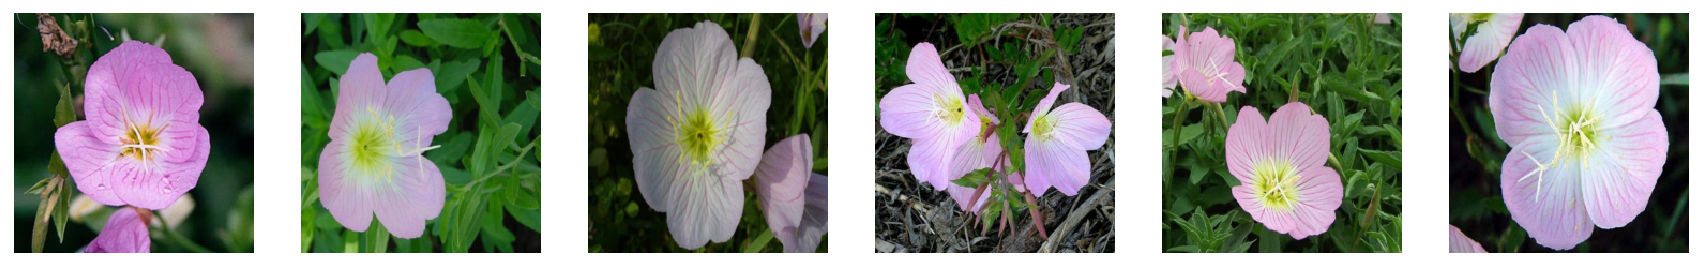

In [15]:
show_six(dummy_train_loader)

With data augmentation:

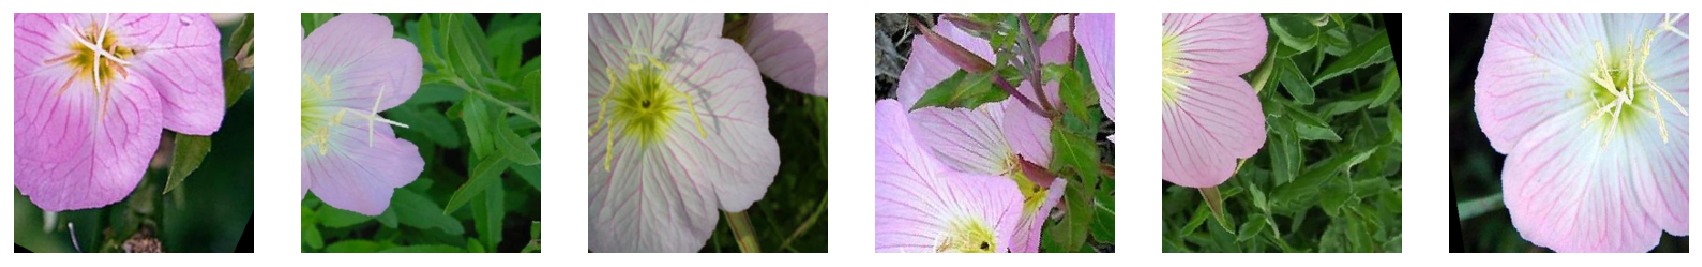

In [16]:
show_six(train_loader)

We can see how images are resized, cropped, rotated and flipped.

An example of images for the testing dataset:

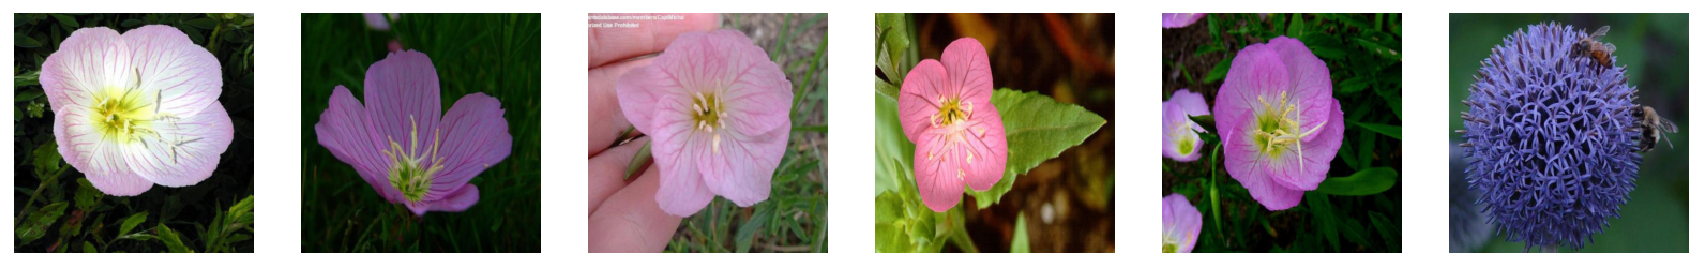

In [17]:
show_six(test_loader)

An example of images for the validation dataset:

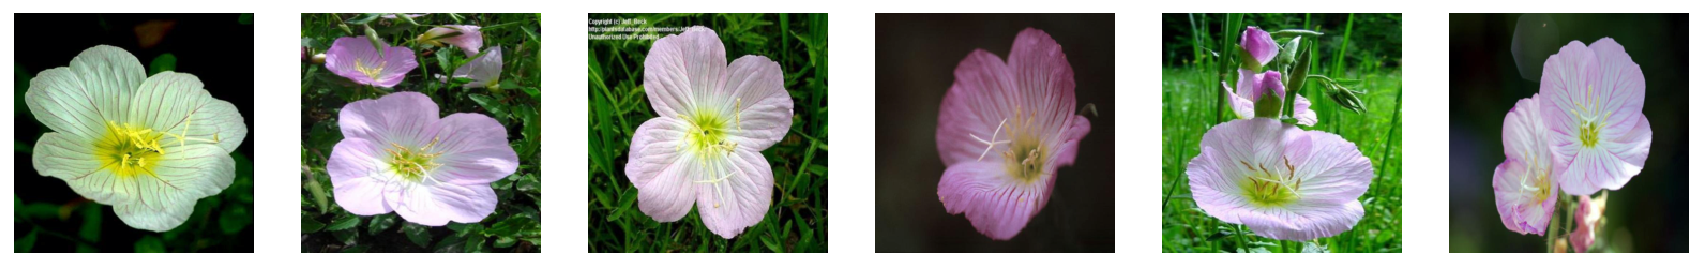

In [18]:
show_six(valid_loader)

We now re-create the train loader so that it's properly shuffled:

In [19]:
loaders = configure_loaders(train_dir, valid_dir, test_dir, batch_size, shuffle=True)
train_loader, valid_loader, test_loader, dummy_train_loader = loaders

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [20]:
cat_to_name = load_categories('cat_to_name.json')
print(cat_to_name)

{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54': 's

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

## Transfer learning

We will use a pre-trained model on ImageNet dataset. These models are generally composed of a convolutional neuron network and a fully-connected neuron network. The convolutional part acts as a feature-extractor for the second part of the model which is a classifier. The idea is then only to re-use the feature-extracor part of the model and keep it as is while we find the best neural network architecture for the classifier part.

### VGG16 model (without batch normalization)

In [21]:
model = models.vgg16(pretrained=True)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

The VGG16 model without batch normalization claims a top-1 error of 28.41% and a top-5 error of 9.62%. This means that the output with higher probability is wrong 28.41% of the time on the validation dataset. The probability of having the right answer from the first 5 propabilities is higher than 90%. Those scores are evaluated on the   [ImageNet](http://www.image-net.org/) dataset.

The VGG16 model has 3 different parts:
    
- a feature-extractor (`features`) composed of Conv2d ([2D convolution](https://pytorch.org/docs/master/nn.html#conv2d)), MaxPool2d ([2D max pooling](https://pytorch.org/docs/master/nn.html#maxpool2d)) and ReLU ([Rectified linear unit](https://pytorch.org/docs/master/nn.html#relu))activation units
- an averaged pool unit composed of [AdapativeAvgPool2d](https://pytorch.org/docs/master/nn.html#adaptiveavgpool2d)
- a classifier composed of [linear](https://pytorch.org/docs/master/nn.html?highlight=linear#torch.nn.Linear) fully-connected neurons, [ReLU](https://pytorch.org/docs/master/nn.html#relu) activations and [Dropout](https://pytorch.org/docs/master/nn.html#dropout).

The classifier has 3 layers of 25088, 4096 and 1000 neurons. There is no activation on the last layer so the output of the neuron network are scores.

We will freeze the feature-extractor and the average pool unit and implement our own classifier.

### ResNext101-32x8d

In [22]:
model = models.resnext101_32x8d(pretrained=True)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

The ResNext101-32x8d model without batch normalization claims a top-1 error of 20.69% and a top-5 error of 5.47%. This means that the output with higher probability is wrong 20.69% of the time on the validation dataset. The probability of having the right answer from the first 5 propabilities is higher than 94%. Those scores are evaluated on the [ImageNet](http://www.image-net.org/) dataset.

The ResNext101-32x8d model has 3 different parts:
    
- a feature-extractor composed of Conv2d ([2D convolution](https://pytorch.org/docs/master/nn.html#conv2d)), BatchNorm2d ([4D batch normalization](https://pytorch.org/docs/stable/nn.html#batchnorm2d)) and ReLU ([Rectified linear unit](https://pytorch.org/docs/master/nn.html#relu))activation units
- an averaged pool unit composed of [AdapativeAvgPool2d](https://pytorch.org/docs/master/nn.html#adaptiveavgpool2d)
- a classifier composed of [linear](https://pytorch.org/docs/master/nn.html?highlight=linear#torch.nn.Linear) fully-connected neurons.

The classifier has 2 layers of 2048 and 1000 neurons. There is no activation on the last layer so the output of the neuron network are scores.

We will freeze the feature-extractor and the average pool unit and implement our own classifier.

## Build the flower classifier model

The following parametric function creates the classifier neuron network we will train in this project. By default, the first layer of our classifier has 25088 neurons and the last one has 102 (the number of different species of flowers). This is when VGG16 model is used in transfer learning. Otherwise the number of input layers is 2048 when ResNext101-32x8d model is used. It is possible to add additional layers between both thanks to the `layers` attributes. Dropout is used on all layers except the last one with a probability of `dropout`. `activation` activation function is used on all layers except last one which uses a softmax. The model predicts the probabilities of being in a specific class.

In [23]:
build_neuron_network()

Sequential(
  (output): Linear(in_features=25088, out_features=102, bias=True)
  (softmax): Softmax(dim=1)
)

We now implement a PyTorch [Module](https://pytorch.org/docs/stable/nn.html#torch.nn.Module).

The following class prepares a model and optimizer for the training process.

The neural network architecture is controled with the following parameters:
- `model`: select the pre-trained model (either VGG16 or ResNext101-32x8d) [default: VGG16]
- `layers`: size inner layers (the input and output are fixed to 25088 (or 2048) and 102 by default)
- `dropout`: probability of droping out neurons (not for output layer) [default: 0.2]
- `activation`: activation function to be used for all layers except the output [default: relu]

The optimizer is controled with the following parameters:
- `learning_rate`: coefficient applied to each gradient before updating weights and bias [default: 0.001]
- `optimizer`: optimizer used for the training [default: adam]
- `epochs`: number of epochs for the training [default: 5]

The dropout is used for regularization: at each forward pass, a certain portion of the neural networked is dropout and is not used to make the prediction. The intent is to prevent some weights to be too high and force the all neurons in the network to be complementary. This shall result in a training accuracy increasing with the validation accuracy (on unseen samples) and thus avoid overfitting.

**Note:**
The loss function used is [Negative Log Likelihood](https://pytorch.org/docs/stable/nn.html#nllloss) function. This function expects to have log softmax as input while our model only provides softmax. This means that we have to calculates the log of model predictions before feeding the NLLLoss function. That way we are implementing a cross-entropy loss function like [this](https://pytorch.org/docs/stable/nn.html#crossentropyloss). It is better not to use probabilities in the optimization process itself. This way the model `forward` method can be used to classify images once the model has been trained.

In [24]:
clf = FlowerClassifier()
print(clf)

FlowerClassifier(
  (pretrained): Sequential(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inpla

## Training the model

I have performed several trainings to optimize the hyperparameters of the neural network:

In [25]:
results = load_trade_results()

In [26]:
configurations = [
    dict(model="VGG16", activation="relu", layers=[], epochs=10, optimizer="sgd", dropout=0.2, learning_rate=0.01),
    dict(model="VGG16", activation="relu", layers=[128], epochs=10, optimizer="sgd", dropout=0.2, learning_rate=0.01),
    dict(model="VGG16", activation="relu", layers=[256], epochs=10, optimizer="sgd", dropout=0.2, learning_rate=0.01),
    dict(model="VGG16", activation="relu", layers=[], epochs=10, optimizer="sgd", dropout=0.5, learning_rate=0.01),
    dict(model="VGG16", activation="relu", layers=[128], epochs=10, optimizer="sgd", dropout=0.5, learning_rate=0.01),
    dict(model="VGG16", activation="relu", layers=[256], epochs=10, optimizer="sgd", dropout=0.5, learning_rate=0.01),
    dict(model="VGG16", activation="leaky_relu", layers=[], epochs=10, optimizer="sgd", dropout=0.2, learning_rate=0.01),
    dict(model="VGG16", activation="leaky_relu", layers=[128], epochs=10, optimizer="sgd", dropout=0.2, learning_rate=0.01),
    dict(model="VGG16", activation="leaky_relu", layers=[256], epochs=10, optimizer="sgd", dropout=0.2, learning_rate=0.01),
    dict(model="VGG16", activation="relu", layers=[], epochs=10, optimizer="adam", dropout=0.2, learning_rate=0.0001),
    dict(model="VGG16", activation="relu", layers=[128], epochs=10, optimizer="adam", dropout=0.2, learning_rate=0.0001),
    dict(model="VGG16", activation="relu", layers=[256], epochs=10, optimizer="adam", dropout=0.2, learning_rate=0.0001),
    dict(model="VGG16", activation="relu", layers=[512], epochs=10, optimizer="adam", dropout=0.2, learning_rate=0.0001),
    dict(model="VGG16", activation="relu", layers=[1024], epochs=10, optimizer="adam", dropout=0.2, learning_rate=0.0001),
    dict(model="VGG16", activation="relu", layers=[2048], epochs=10, optimizer="adam", dropout=0.2, learning_rate=0.0001),
    dict(model="VGG16", activation="relu", layers=[4096], epochs=10, optimizer="adam", dropout=0.2, learning_rate=0.0001),
    dict(model="VGG16", activation="relu", layers=[], epochs=10, optimizer="adam", dropout=0.5, learning_rate=0.0001),
    dict(model="VGG16", activation="relu", layers=[128], epochs=10, optimizer="adam", dropout=0.5, learning_rate=0.0001),
    dict(model="VGG16", activation="relu", layers=[256], epochs=10, optimizer="adam", dropout=0.5, learning_rate=0.0001),
    dict(model="VGG16", activation="relu", layers=[512], epochs=10, optimizer="adam", dropout=0.5, learning_rate=0.0001),
    dict(model="VGG16", activation="relu", layers=[1024], epochs=10, optimizer="adam", dropout=0.5, learning_rate=0.0001),
    dict(model="VGG16", activation="relu", layers=[2048], epochs=10, optimizer="adam", dropout=0.5, learning_rate=0.0001),
    dict(model="VGG16", activation="relu", layers=[4096], epochs=10, optimizer="adam", dropout=0.5, learning_rate=0.0001),
    dict(model="VGG16", activation="relu", layers=[512, 256], epochs=10, optimizer="adam", dropout=0.2, learning_rate=0.0001),
    dict(model="VGG16", activation="relu", layers=[1024, 512], epochs=10, optimizer="adam", dropout=0.2, learning_rate=0.0001),
    dict(model="VGG16", activation="relu", layers=[2048, 1024], epochs=10, optimizer="adam", dropout=0.2, learning_rate=0.0001),
    dict(model="VGG16", activation="relu", layers=[4096, 2048], epochs=10, optimizer="adam", dropout=0.2, learning_rate=0.0001),
    dict(model="ResNext101-32x8d", activation="relu", layers=[], epochs=15, optimizer="sgd", dropout=0.2, learning_rate=0.01),
    dict(model="ResNext101-32x8d", activation="relu", layers=[], epochs=15, optimizer="adam", dropout=0.2, learning_rate=0.0001),
    dict(model="ResNext101-32x8d", activation="leaky_relu", layers=[], epochs=15, optimizer="adam", dropout=0.2, learning_rate=0.0001),
    dict(model="ResNext101-32x8d", activation="relu", layers=[], epochs=15, optimizer="adam", dropout=0.5, learning_rate=0.0001),
]

The function below only performs the training if it has not been done before, otherwise it collects from the history of training the convergence history to display it:

In [27]:
def grid_search(configurations):
    for conf in configurations:
        # Check if configuration has been tested already
        skip = False
        for r in results:
            if r["configuration"] == conf:
                #print(f"{conf} skipped because already tested.")
                train_losses = r["train_losses"]
                valid_losses = r["valid_losses"]
                accuracies = r["accuracies"]
                elapsed_times = r["elapsed_times"]
                skip = True
                break
        # Create classifier
        if not skip:
            epochs = conf.pop("epochs")
            print(f"{conf}")
            clf = FlowerClassifier(**conf)
            # Train classifier
            train_losses, valid_losses, accuracies, elapsed_times = clf.fit(train_loader, valid_loader, epochs)
            # Store results
            item = {}
            conf["epochs"] = epochs
            item["configuration"] = conf
            item["train_losses"] = train_losses
            item["valid_losses"] = valid_losses
            item["accuracies"] = accuracies
            item["elapsed_times"] = elapsed_times
            results.append(item)
        # Plot results
        plot_history(train_losses, valid_losses, accuracies, conf)

        # Store results in json file
        save_trade_results(results)

{'model': 'ResNext101-32x8d', 'activation': 'relu', 'layers': [], 'optimizer': 'adam', 'dropout': 0.5, 'learning_rate': 0.0001}
Fitting the model using cuda:0 as device.
Epoch completion: 100.0% Images per second: 43.1 Elapsed time: 152.1 seconds
Epoch: 1/15 Training loss: 4.087 Valid loss: 3.525 Accuracy: 37.0%
Epoch completion: 100.0% Images per second: 41.0 Elapsed time: 319.8 seconds
Epoch: 2/15 Training loss: 3.197 Valid loss: 2.686 Accuracy: 58.1%
Epoch completion: 100.0% Images per second: 40.3 Elapsed time: 487.6 seconds
Epoch: 3/15 Training loss: 2.534 Valid loss: 2.102 Accuracy: 67.5%
Epoch completion: 100.0% Images per second: 40.0 Elapsed time: 655.5 seconds
Epoch: 4/15 Training loss: 2.052 Valid loss: 1.701 Accuracy: 76.8%
Epoch completion: 100.0% Images per second: 39.8 Elapsed time: 823.4 seconds
Epoch: 5/15 Training loss: 1.721 Valid loss: 1.404 Accuracy: 80.0%
Epoch completion: 100.0% Images per second: 39.7 Elapsed time: 991.2 seconds
Epoch: 6/15 Training loss: 1.479 

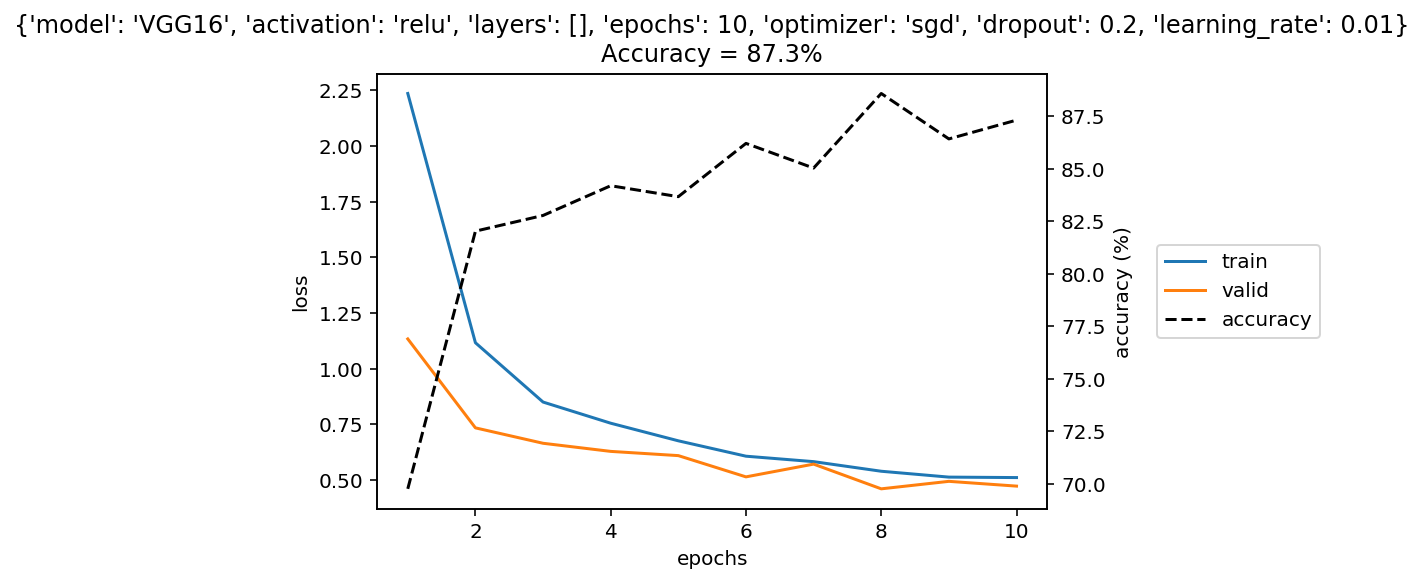

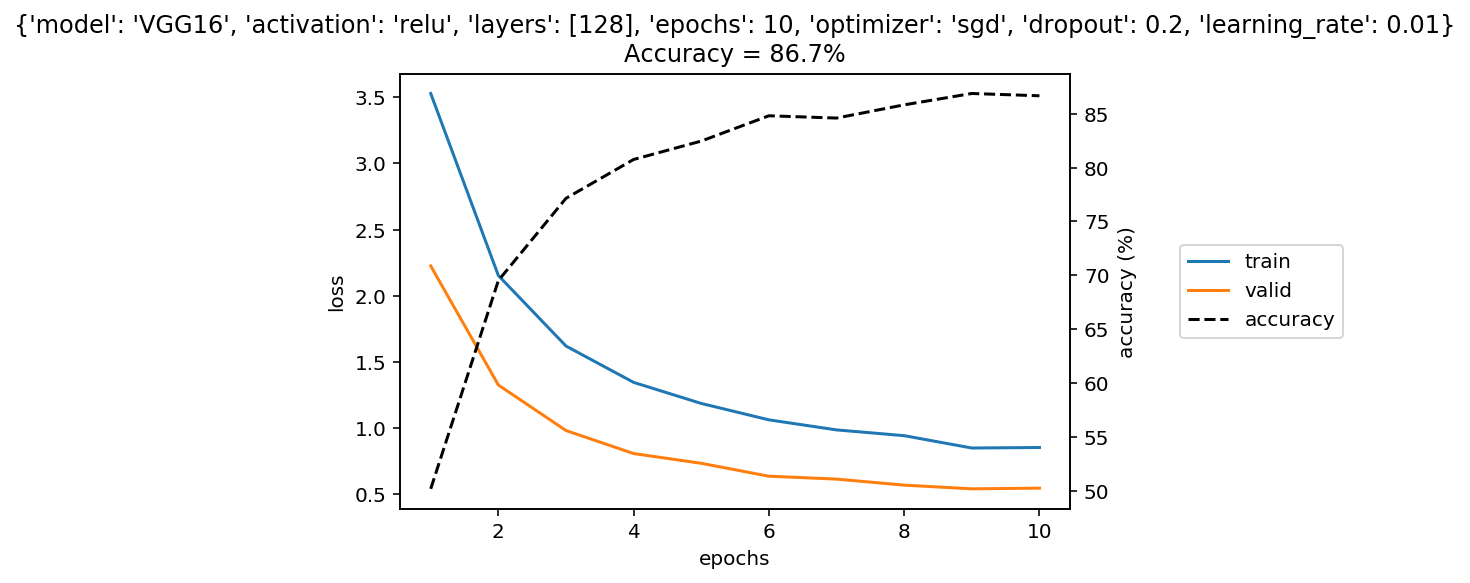

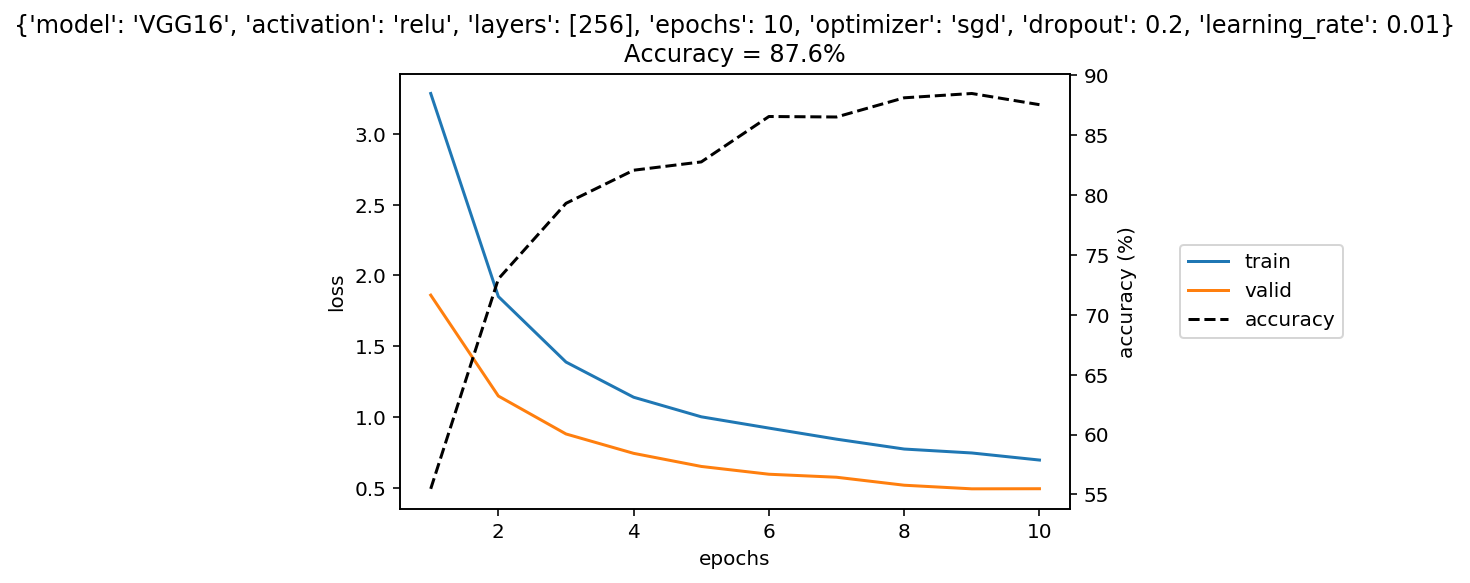

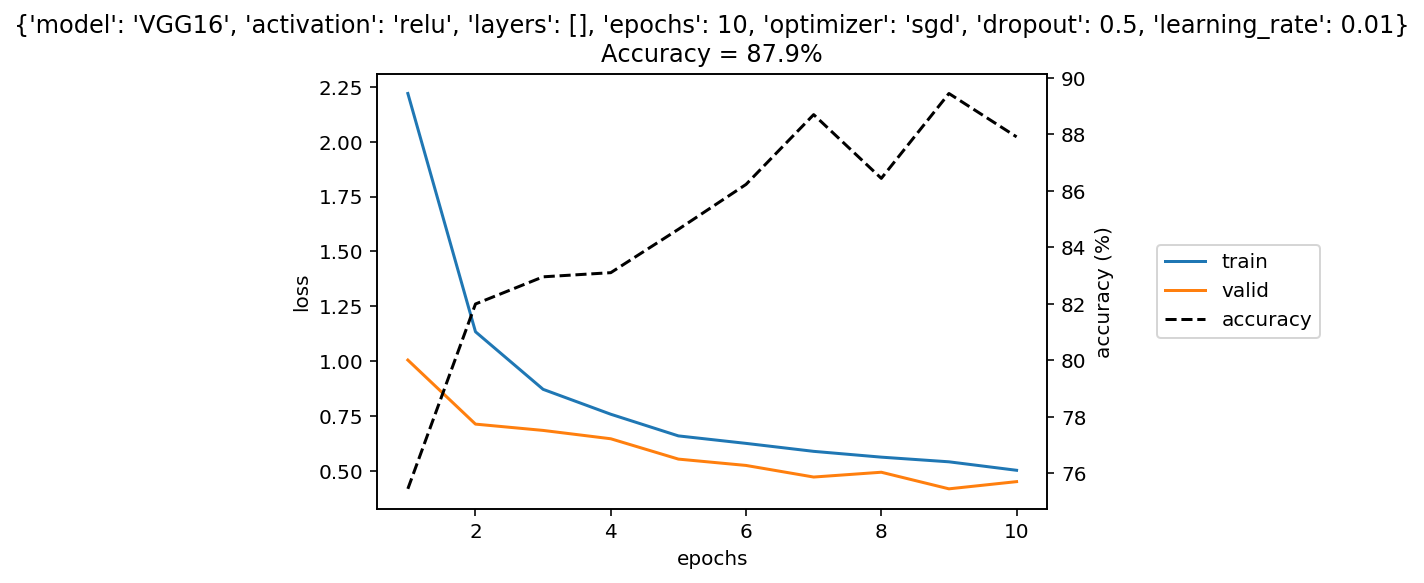

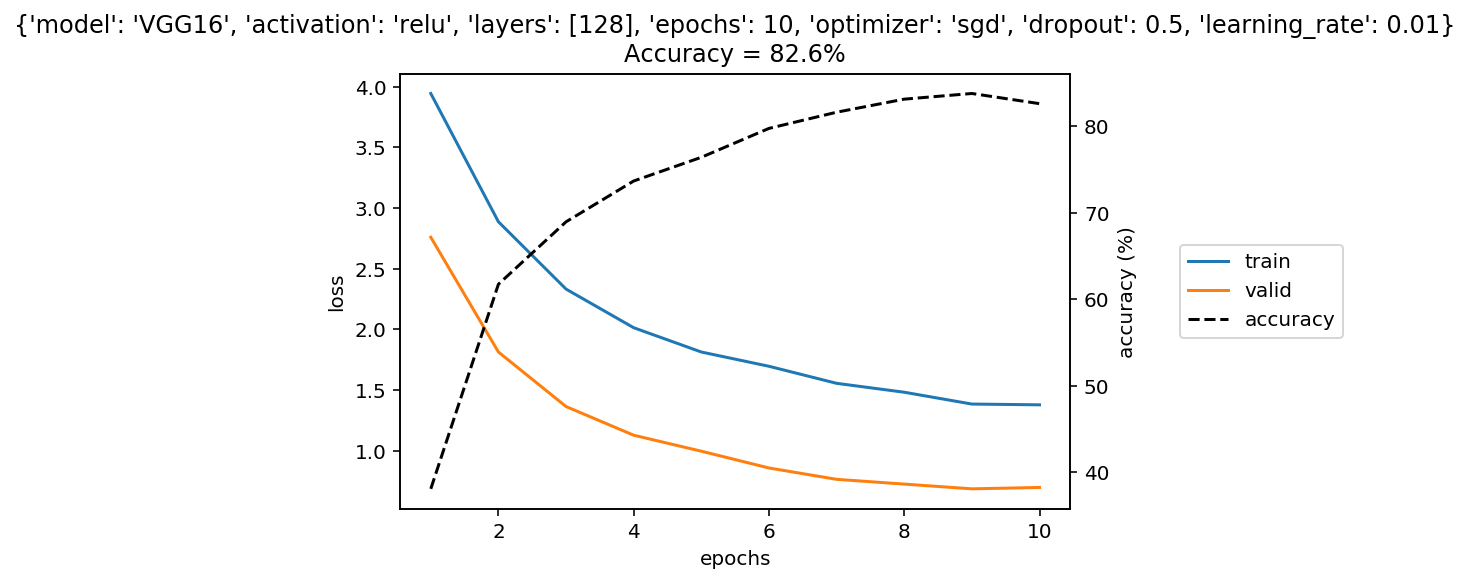

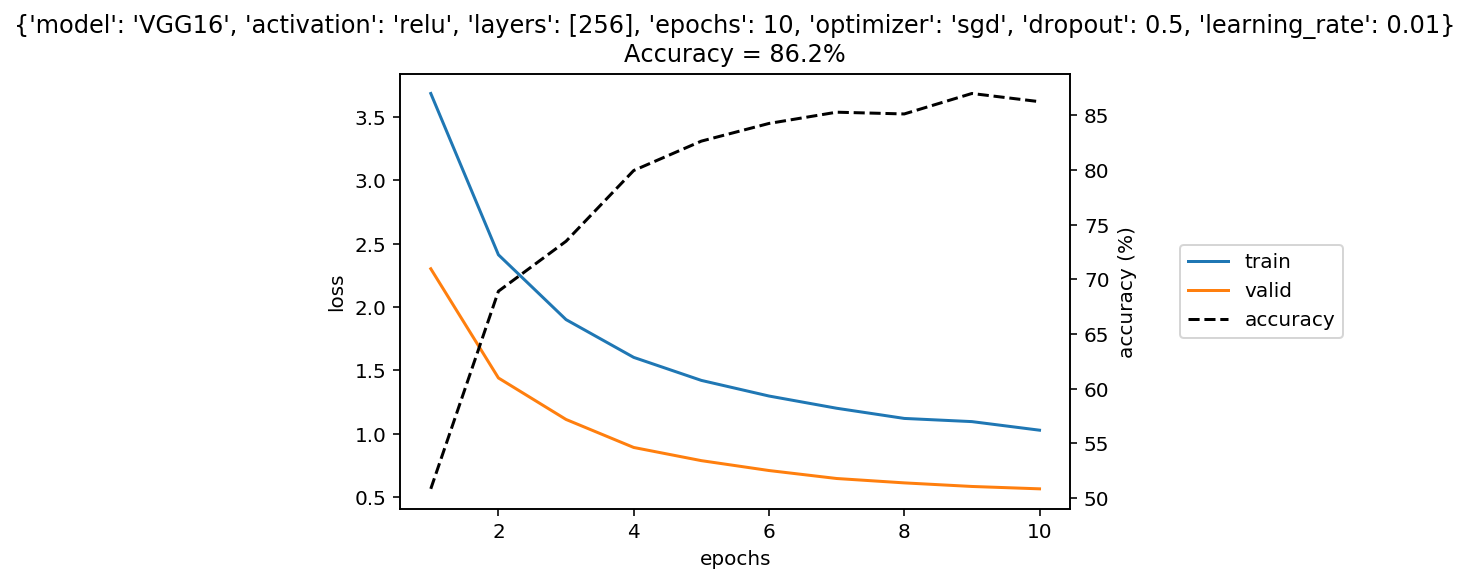

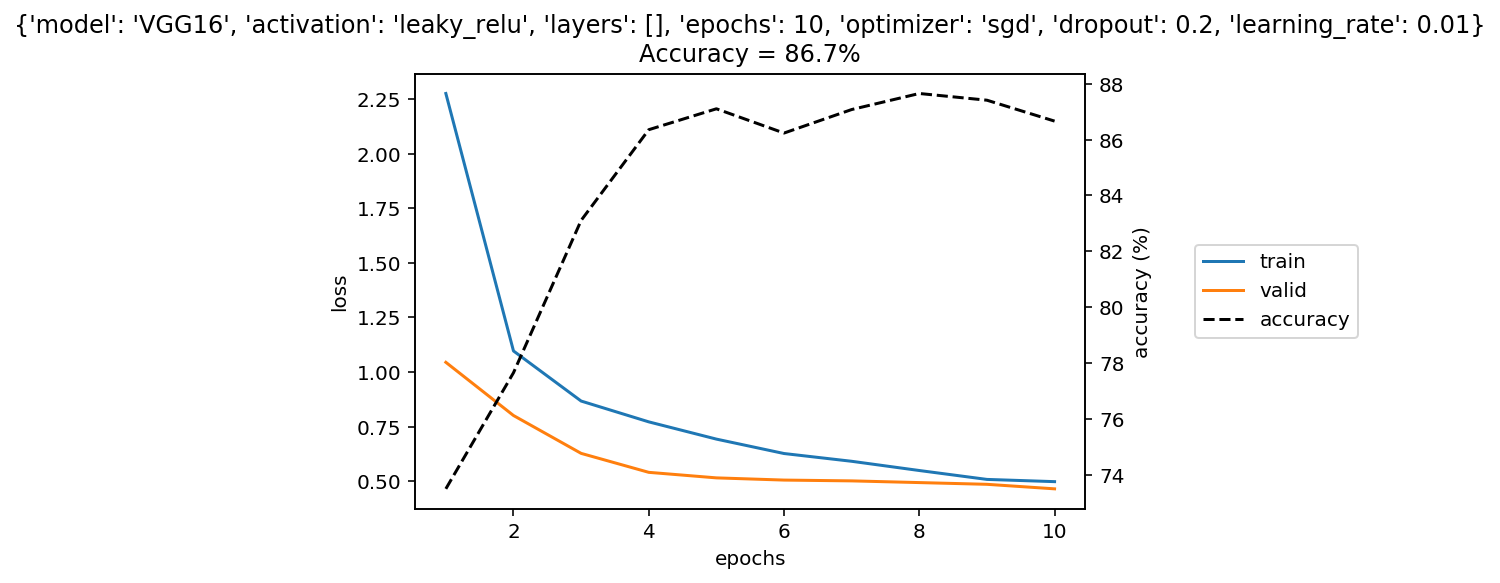

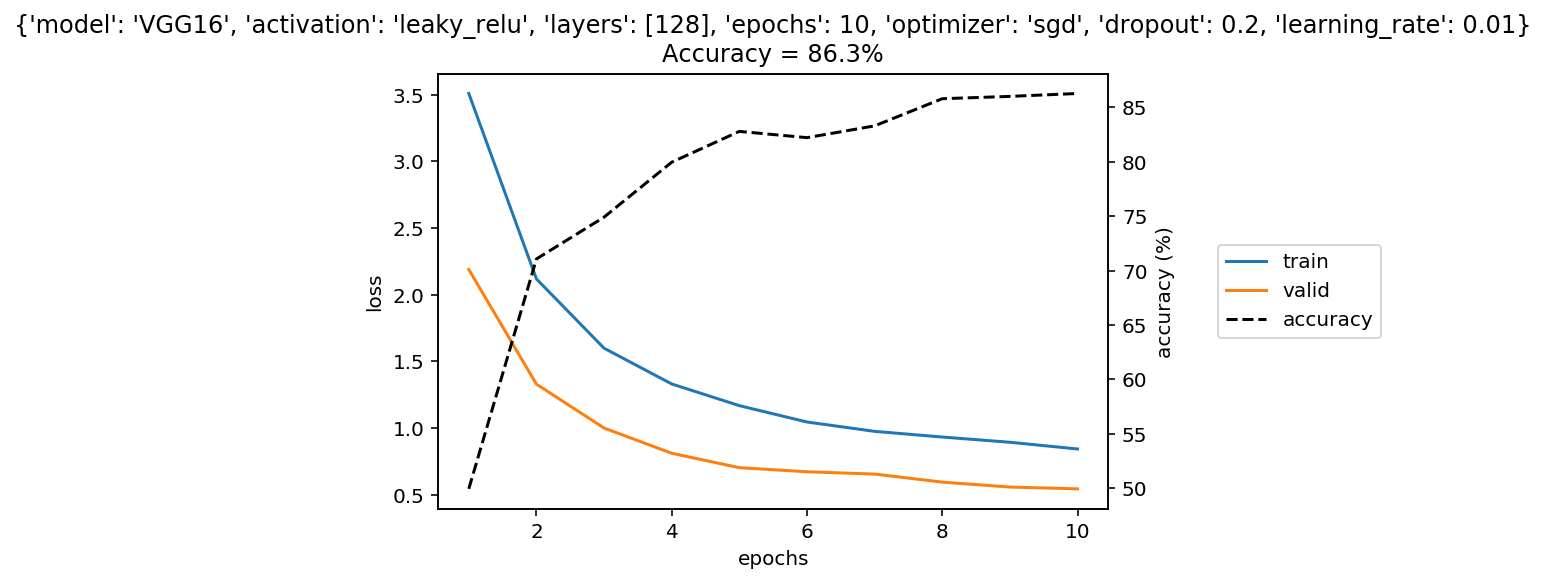

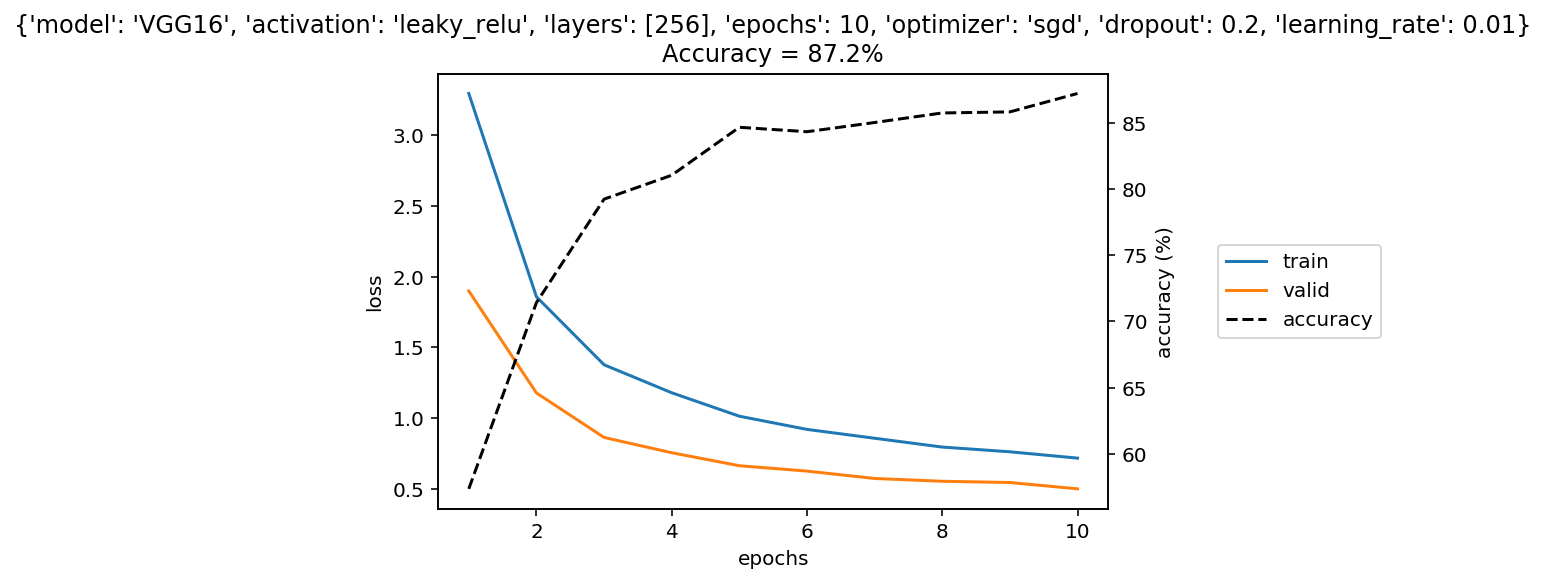

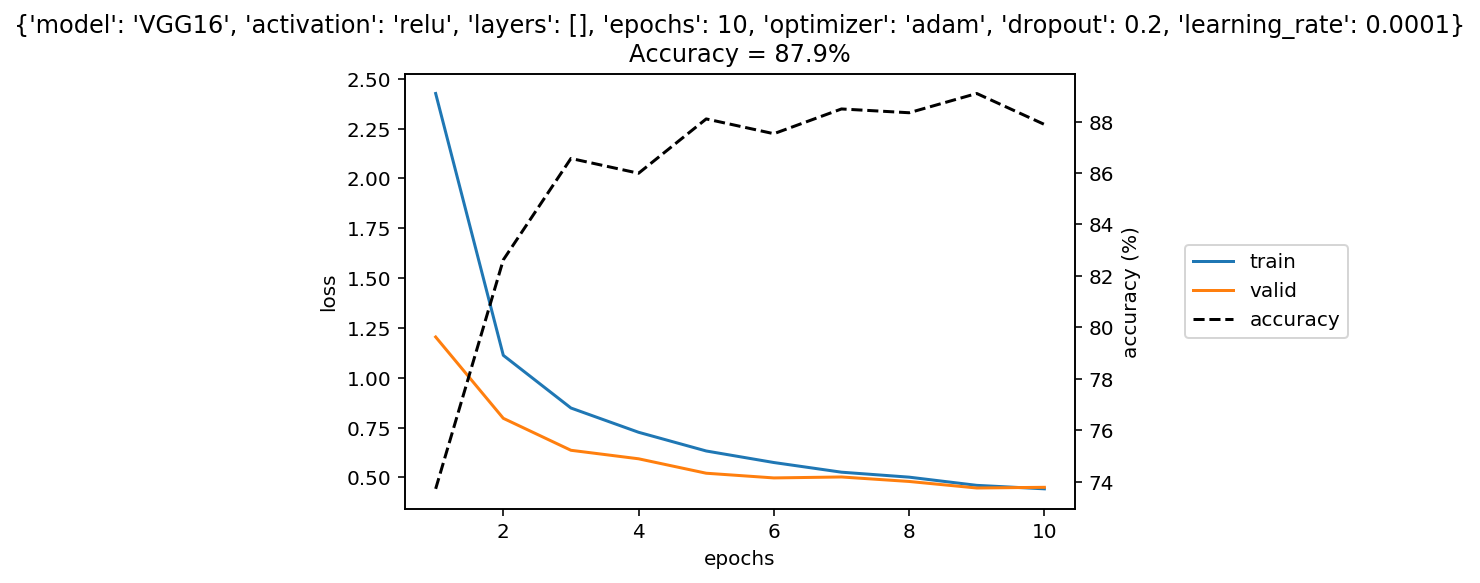

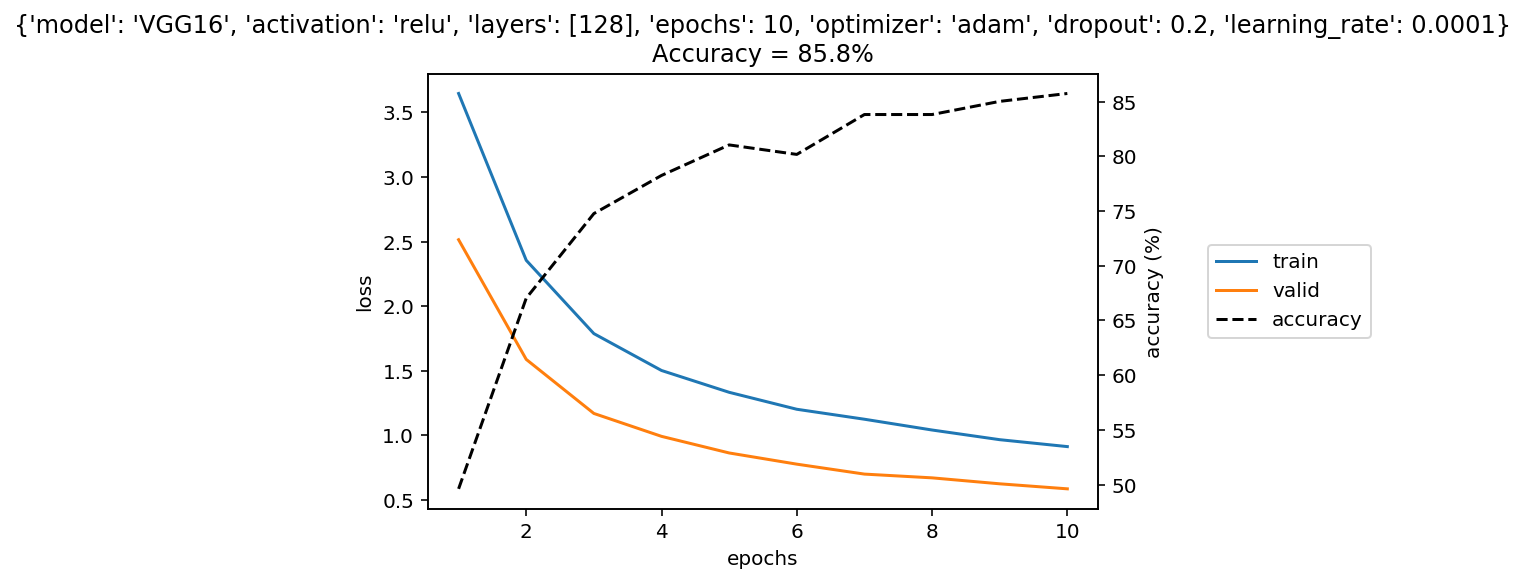

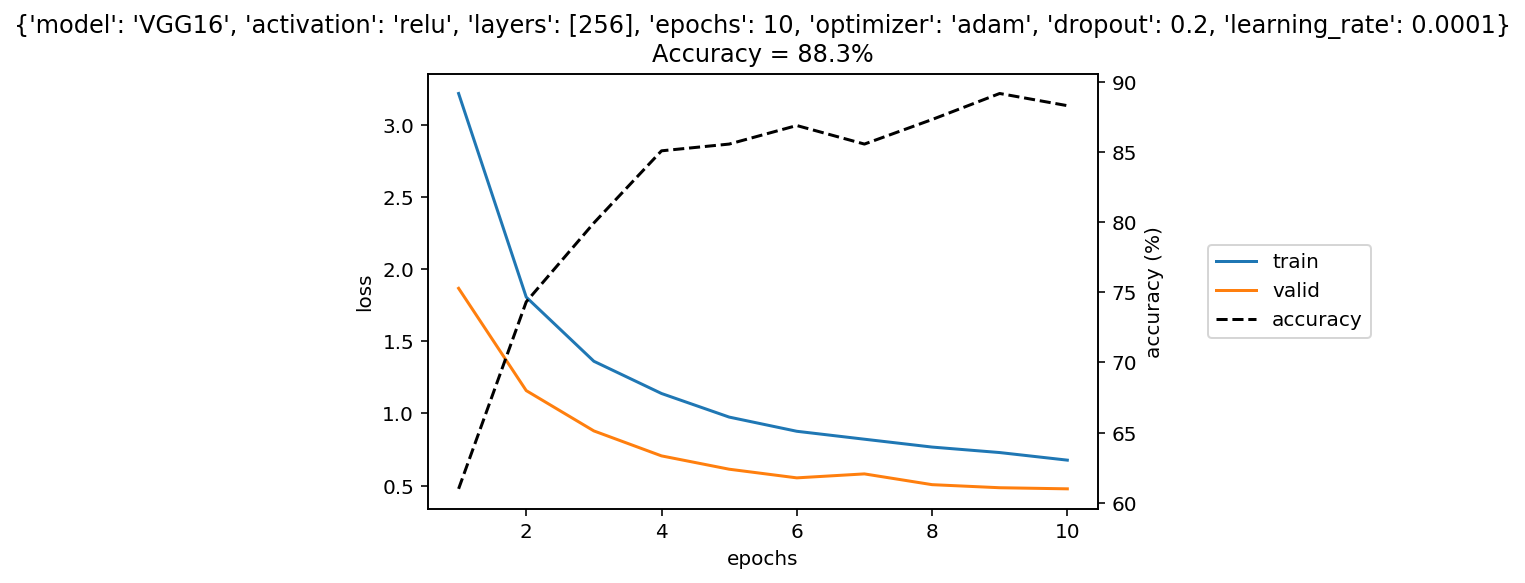

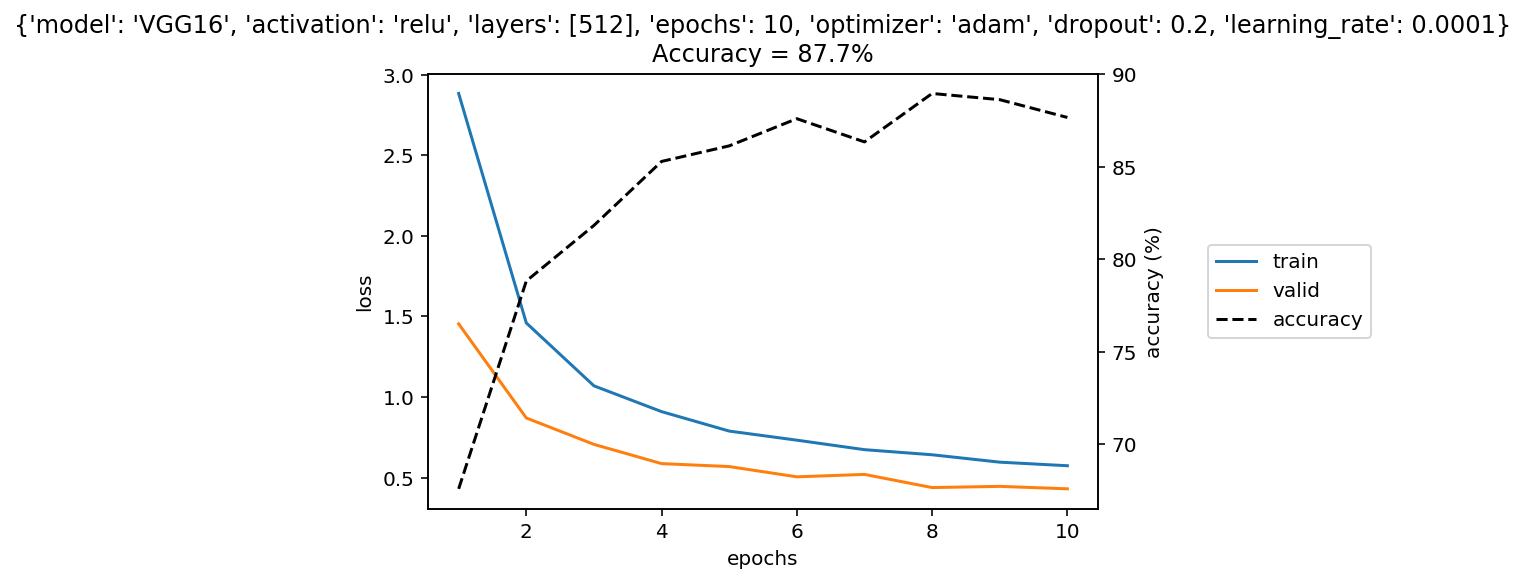

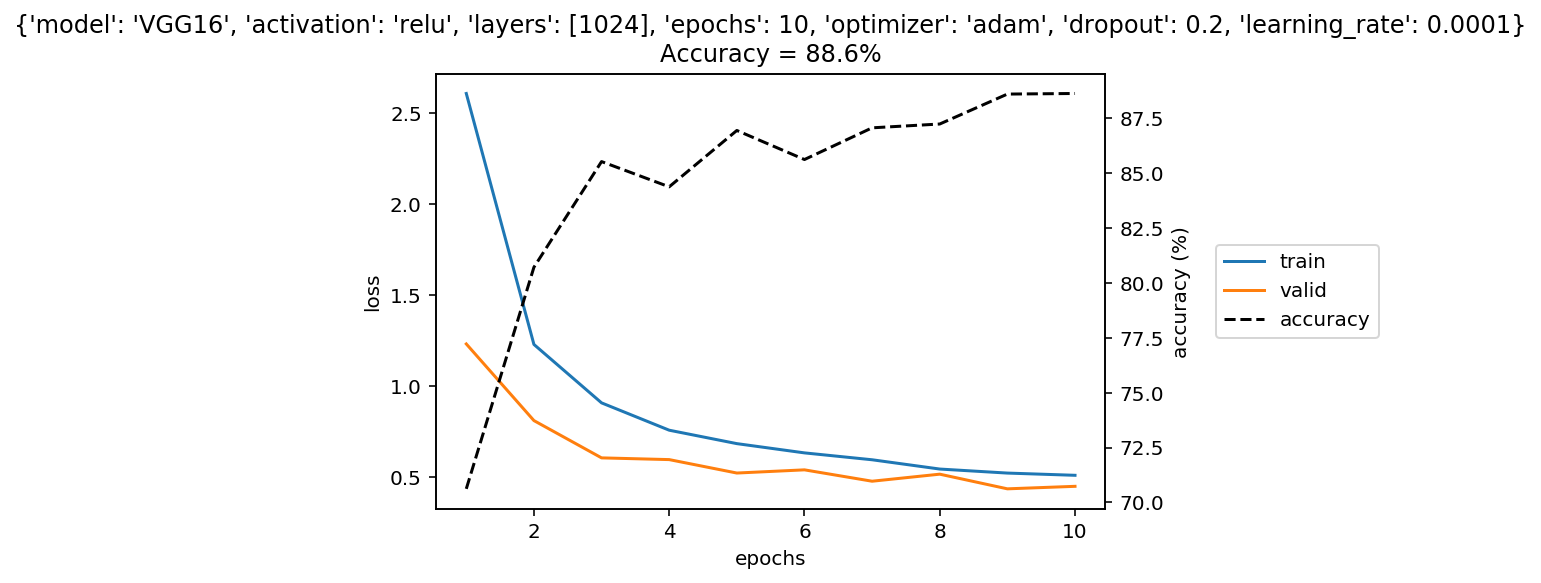

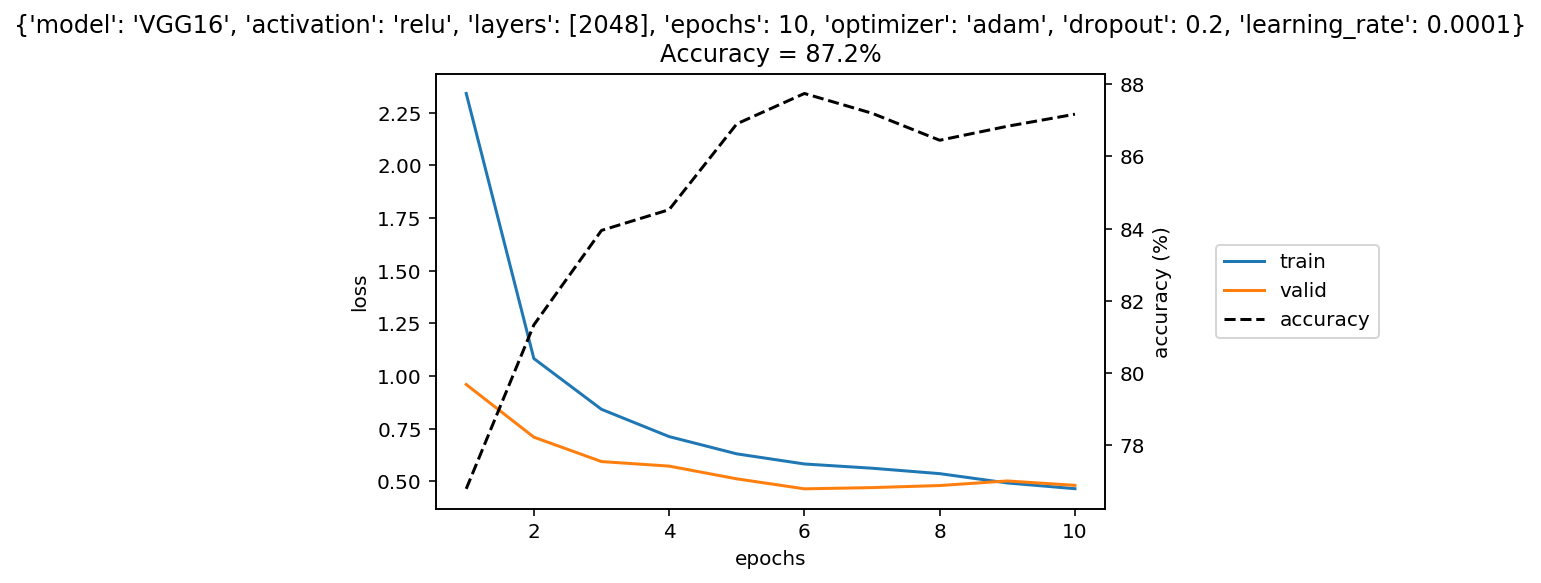

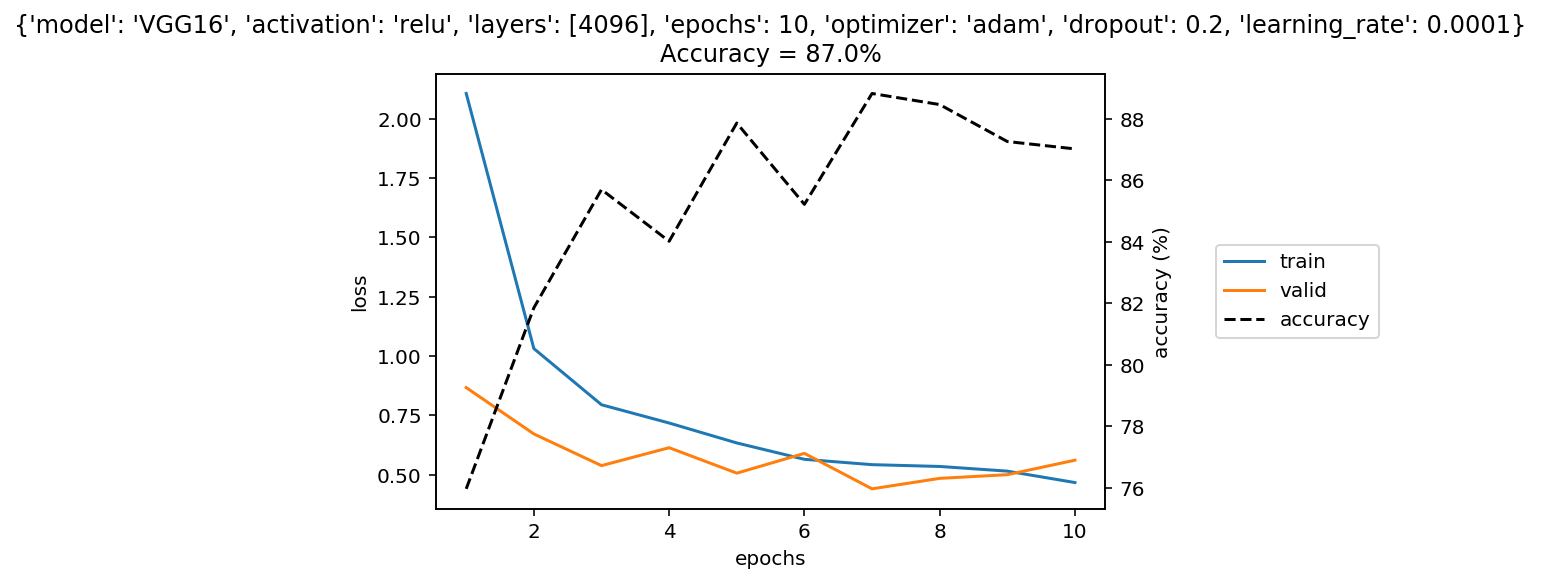

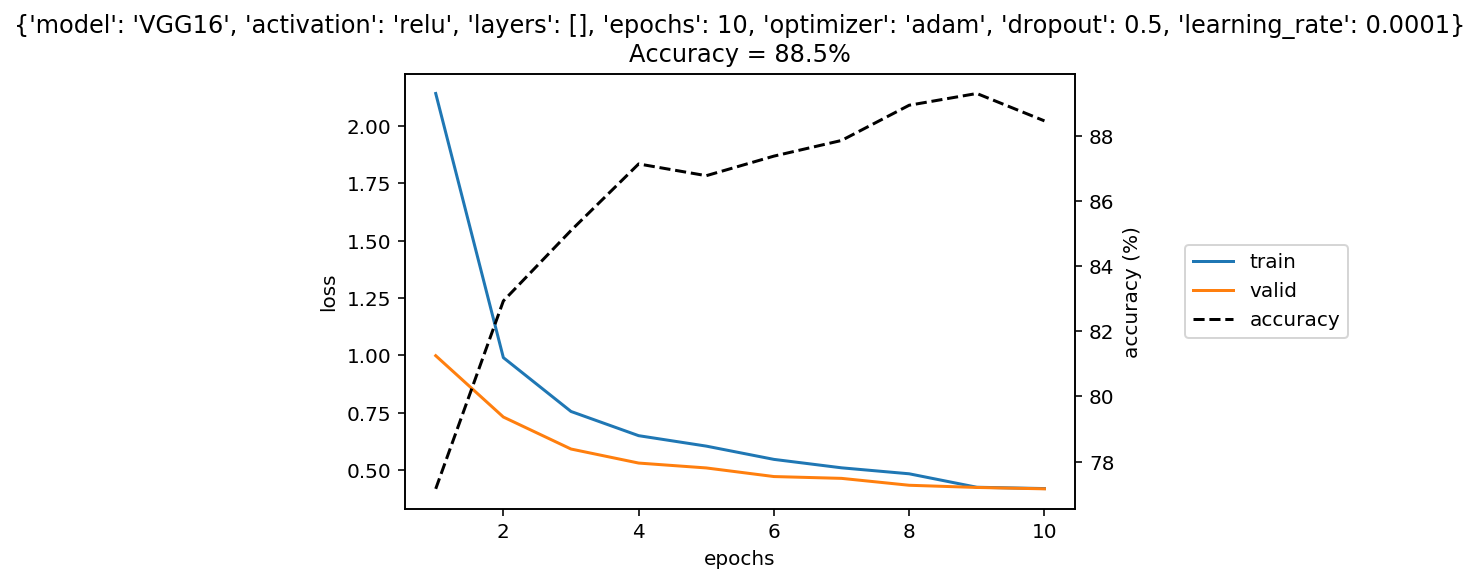

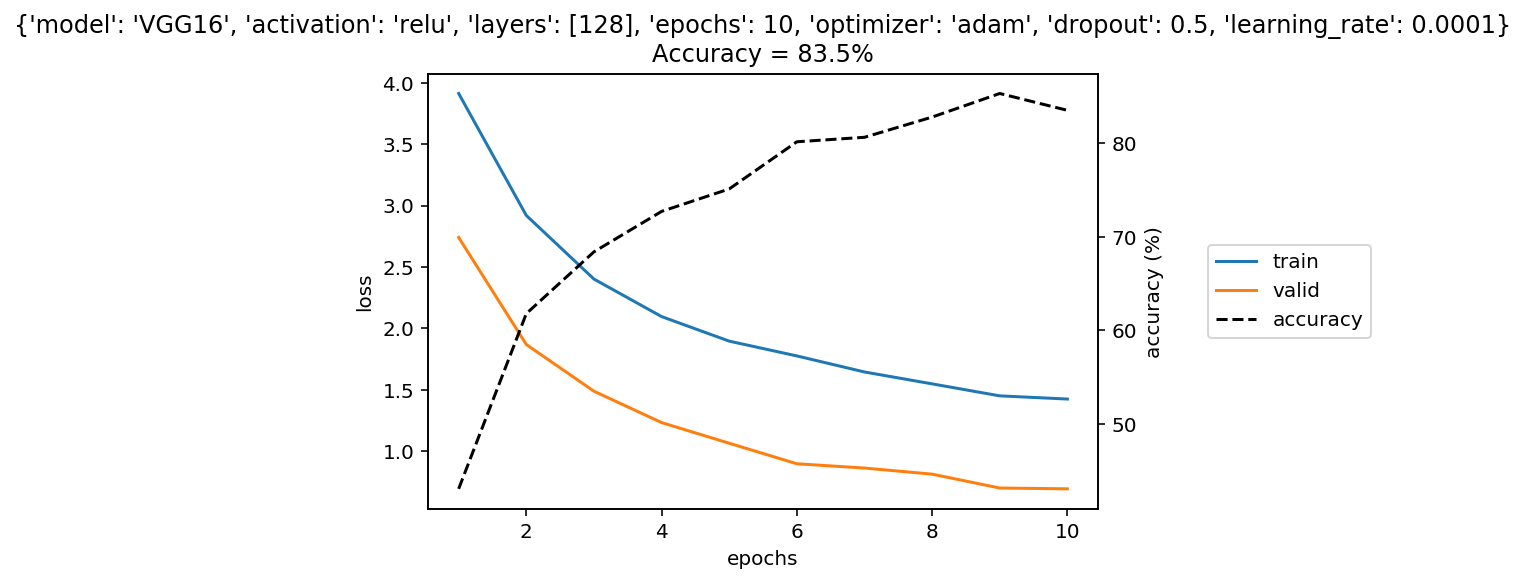

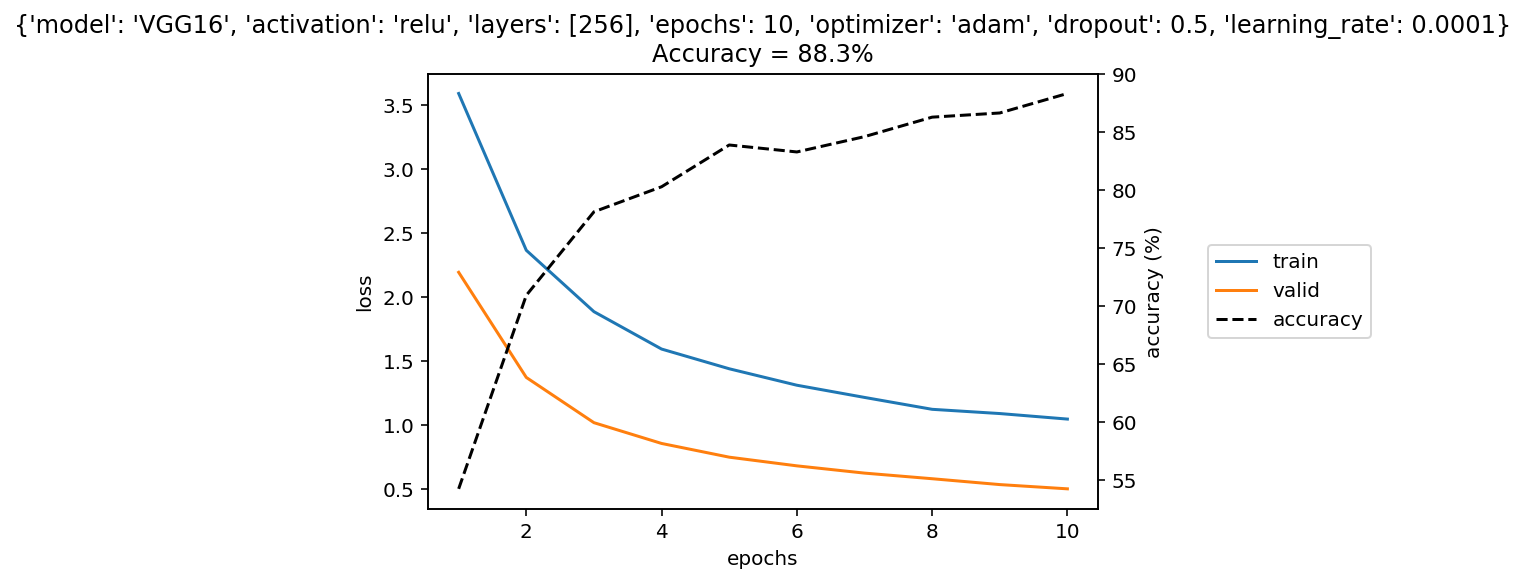

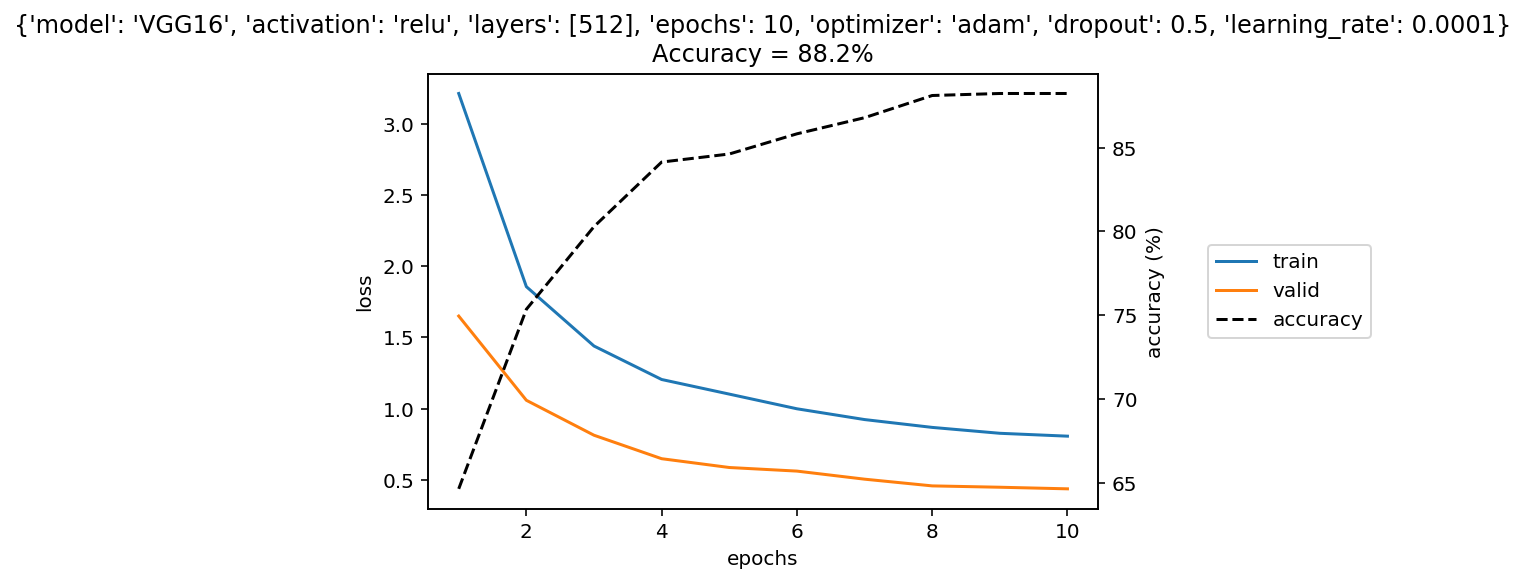

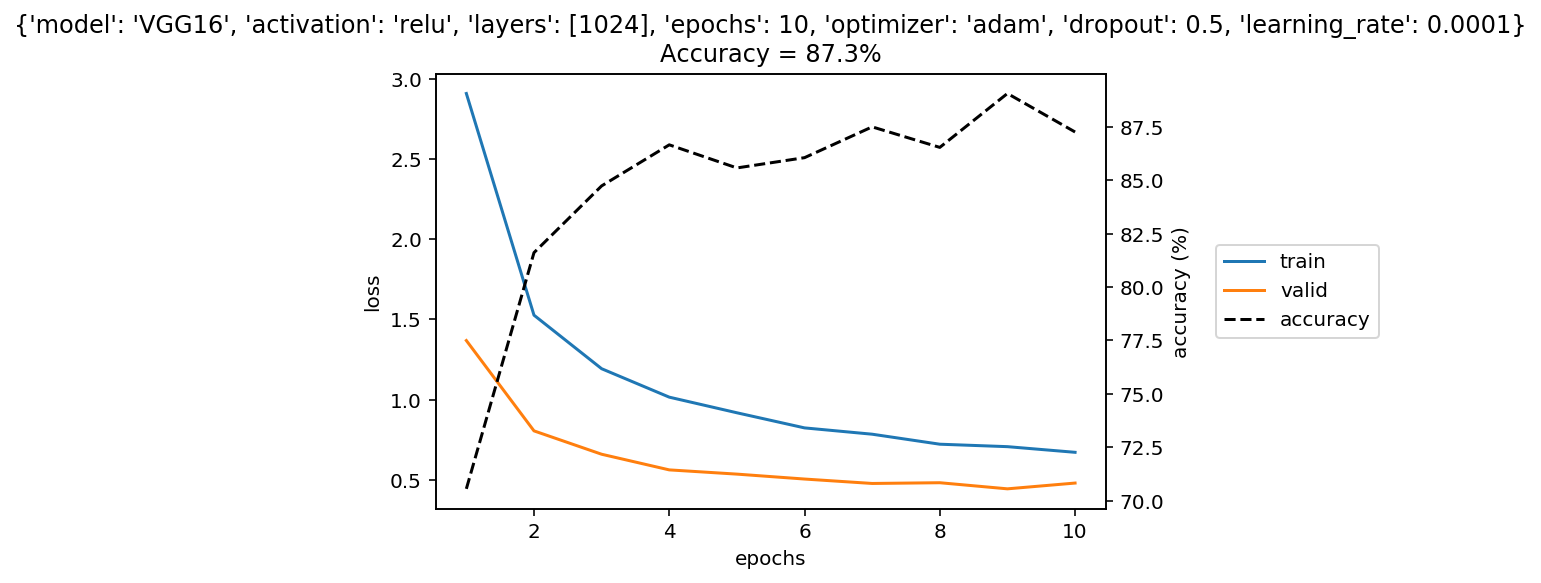

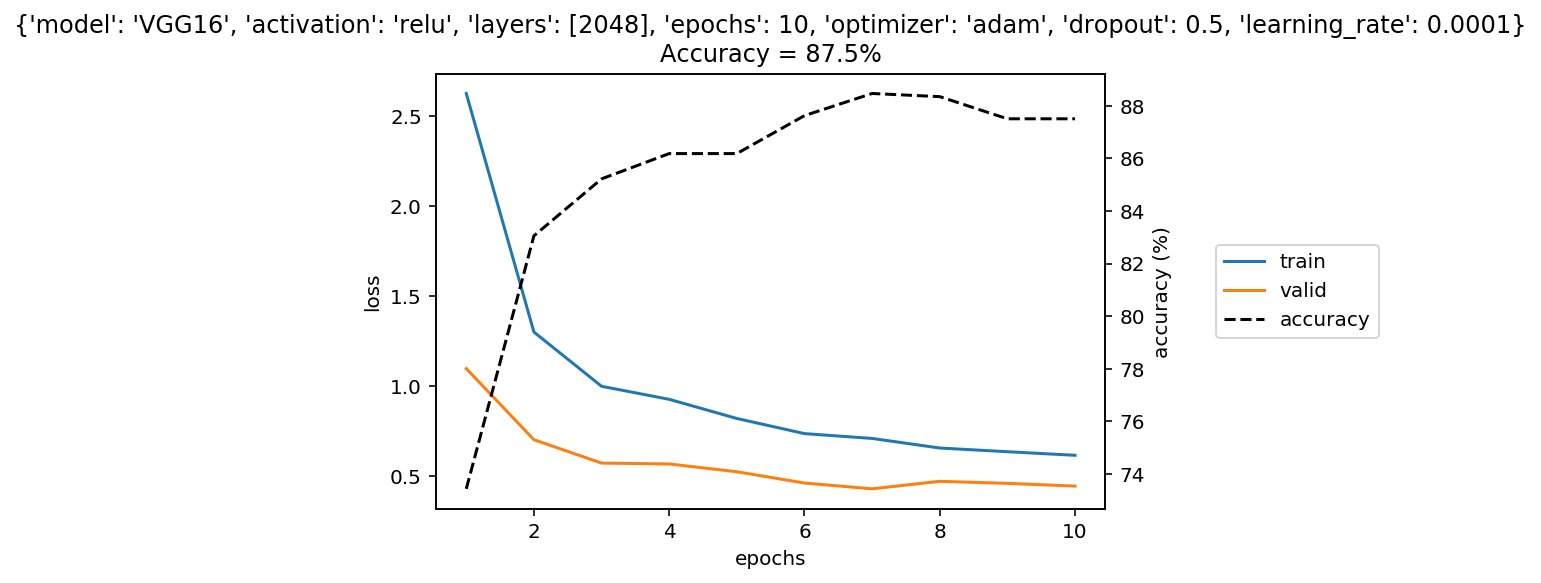

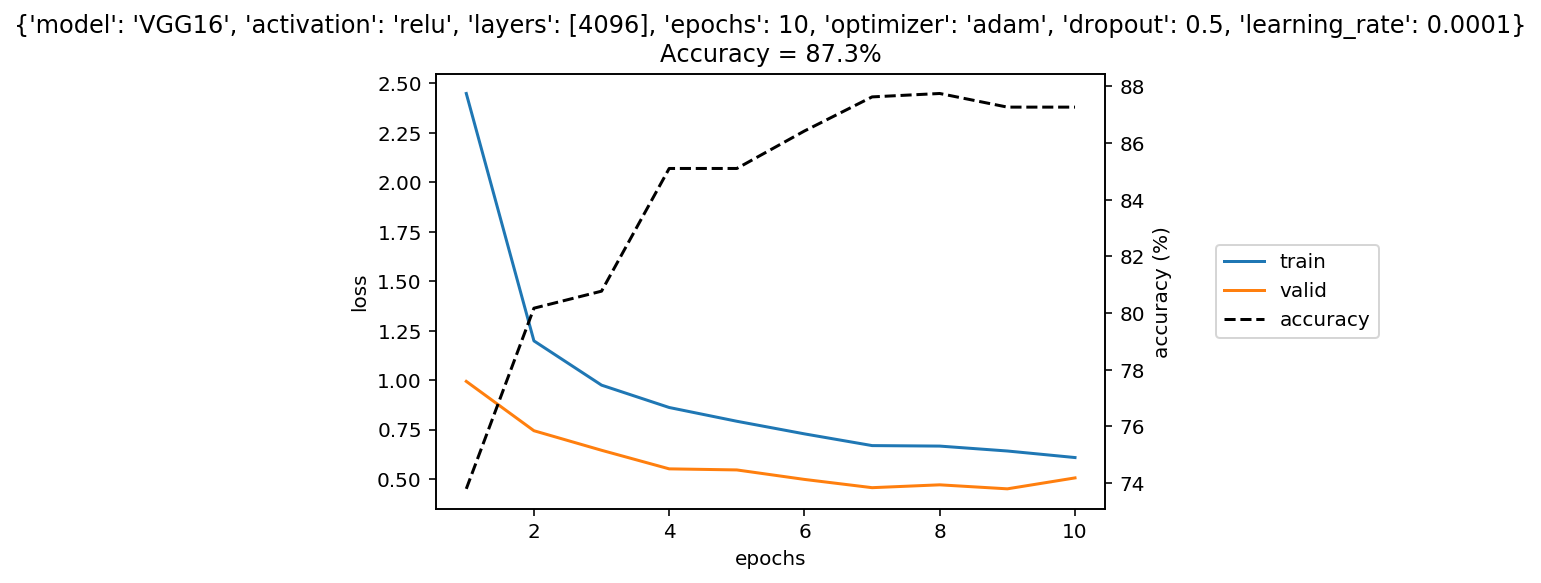

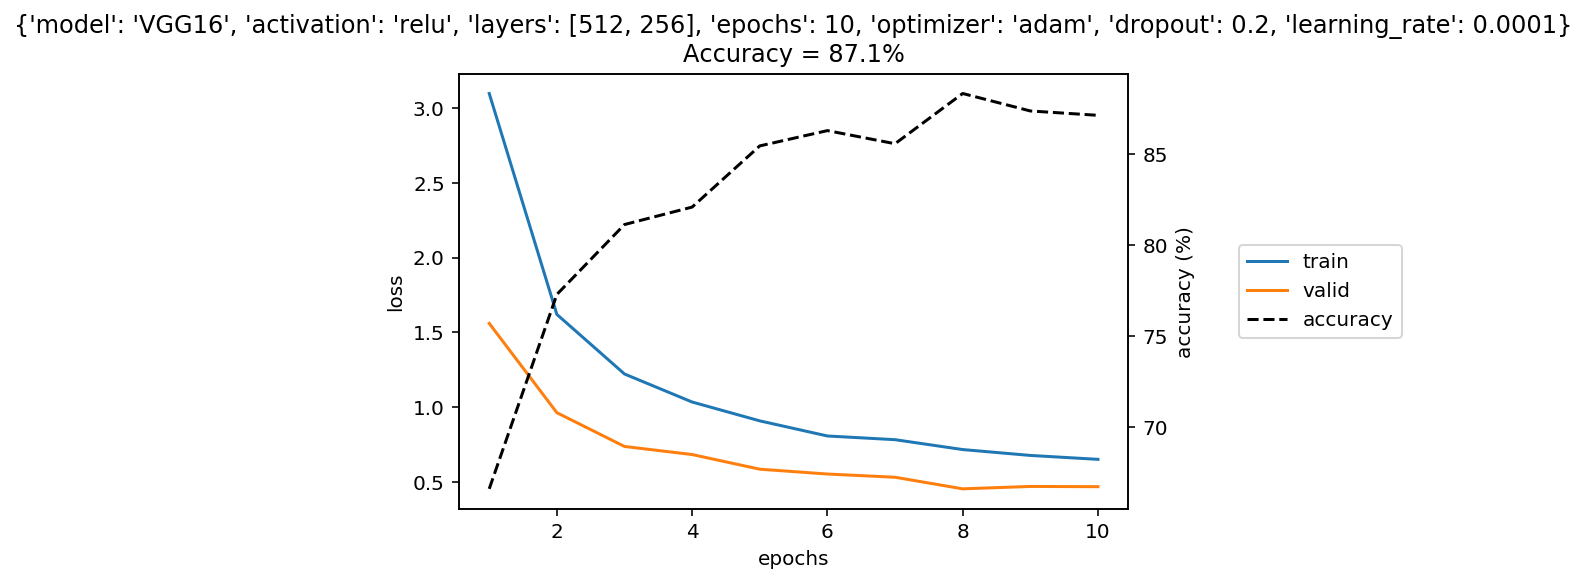

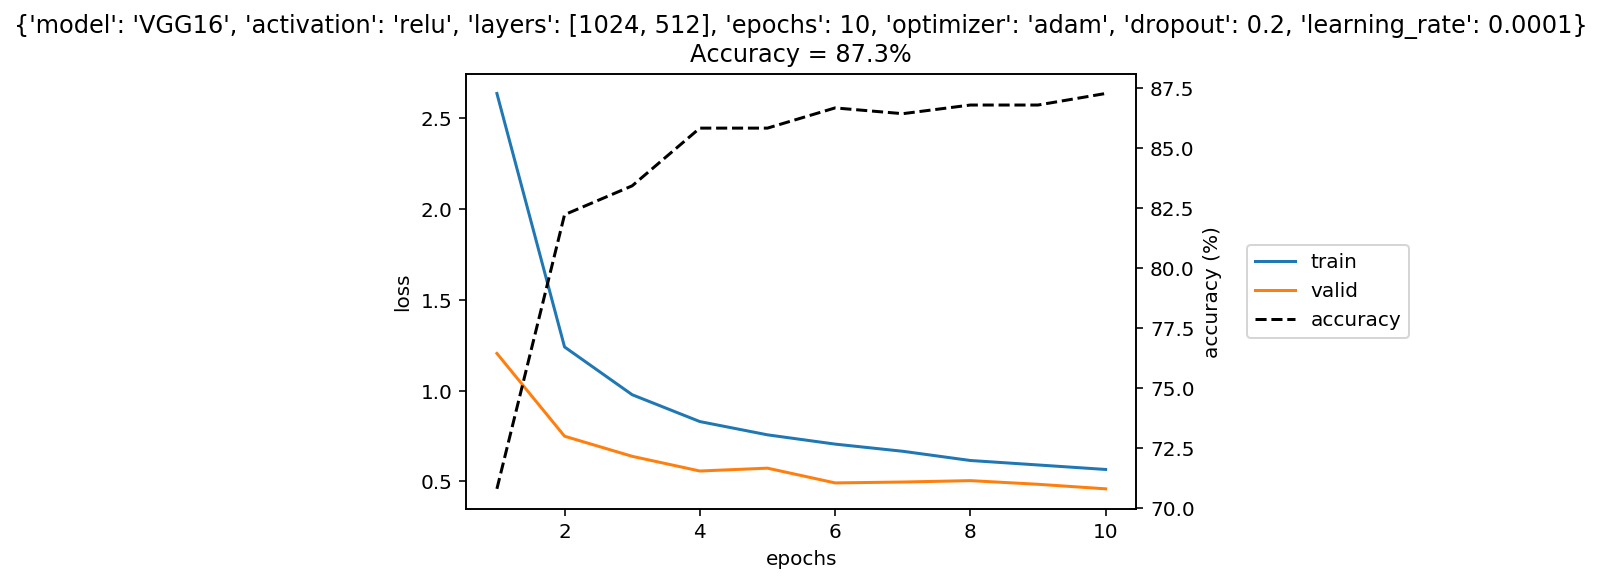

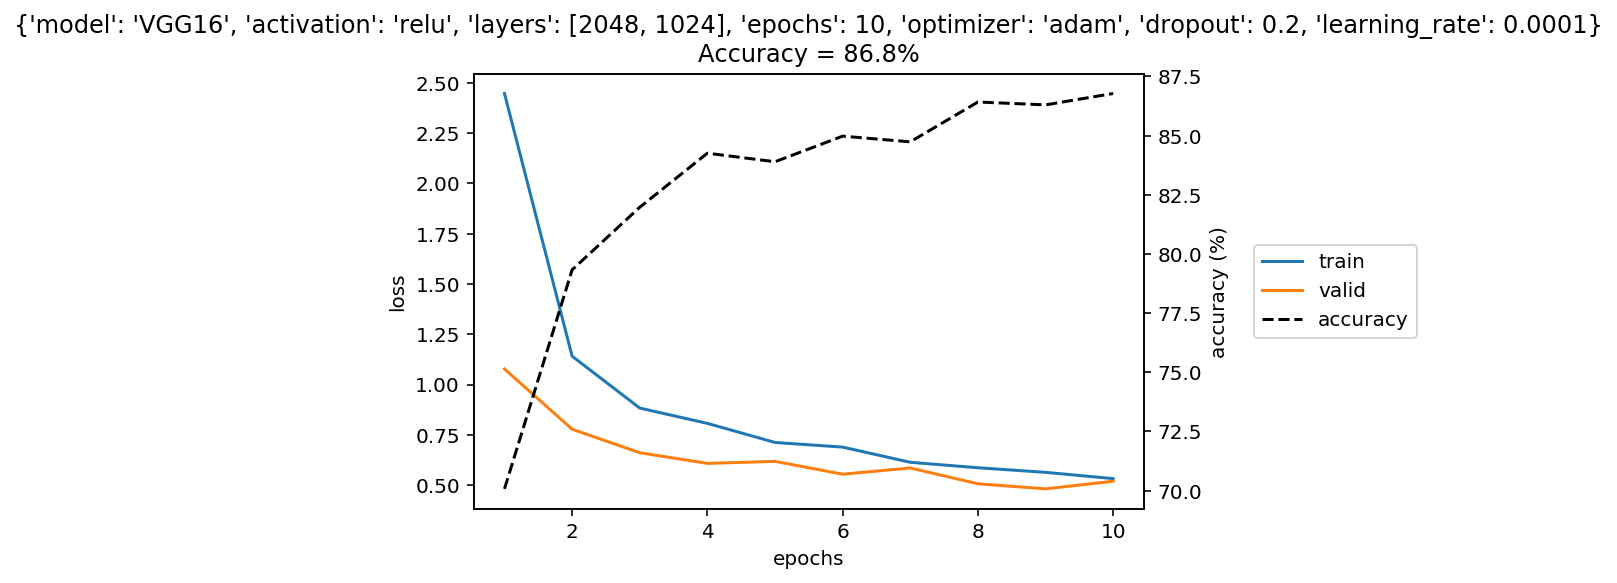

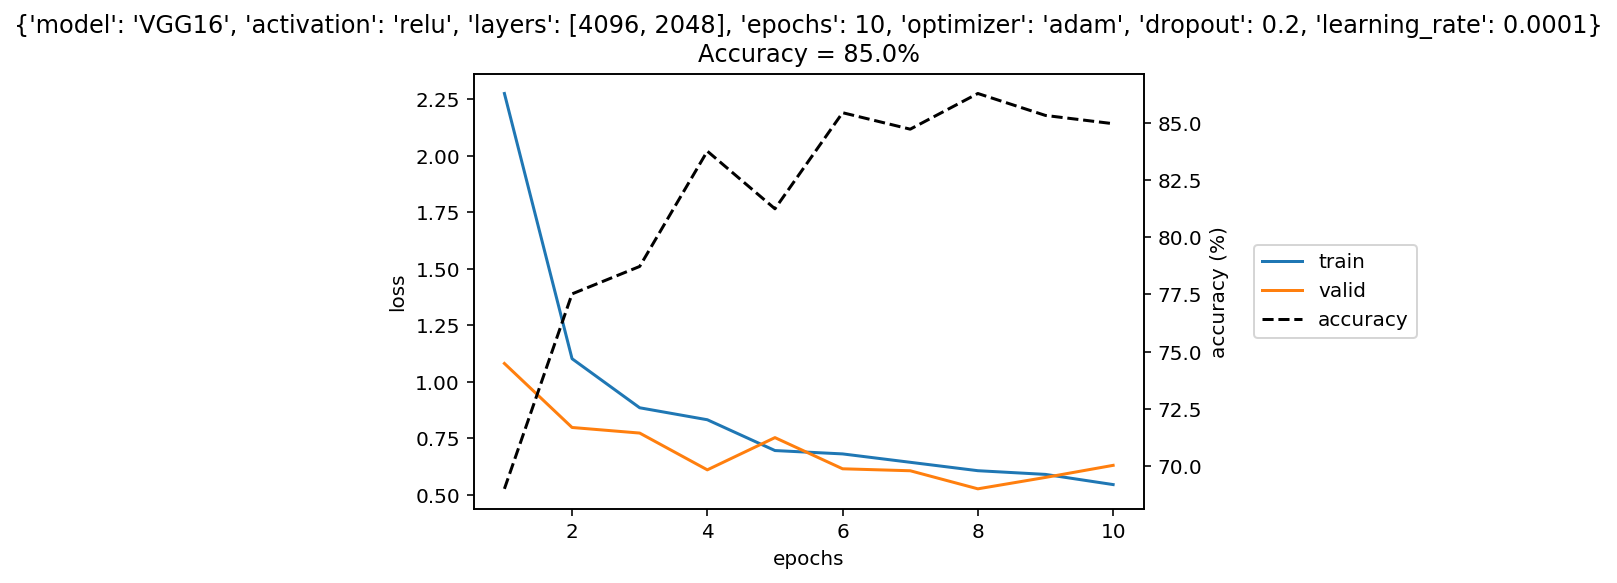

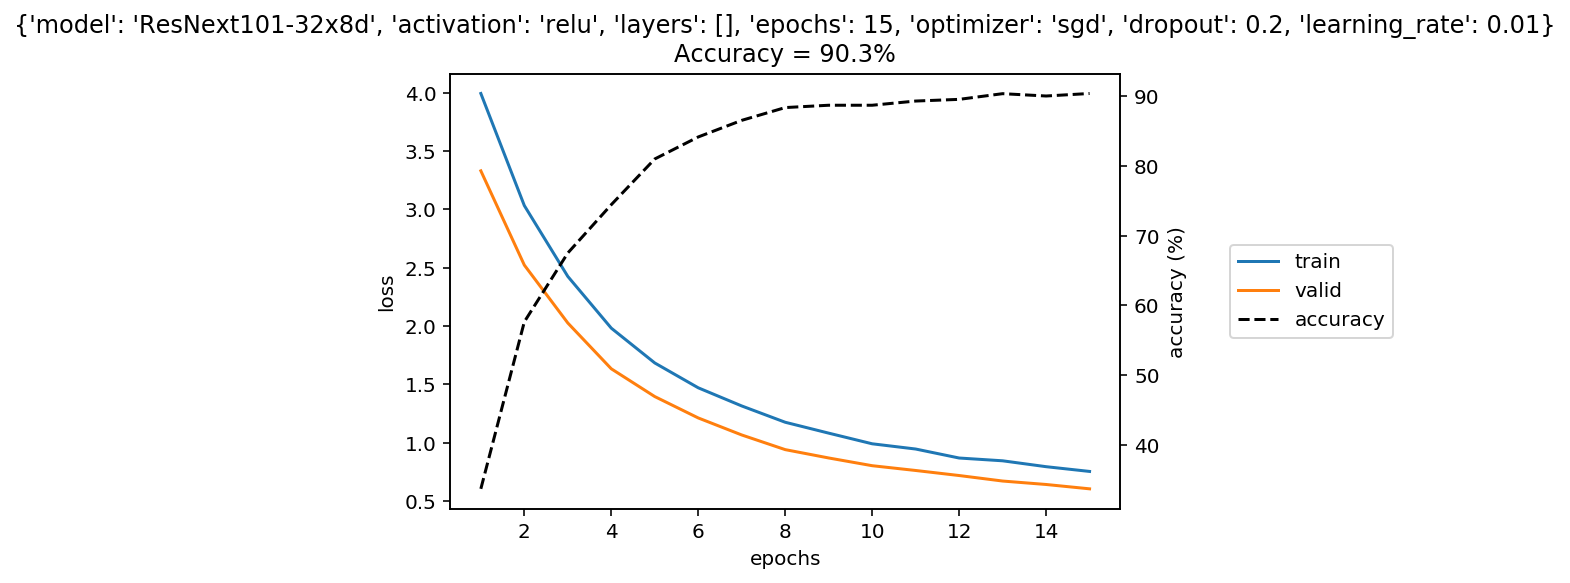

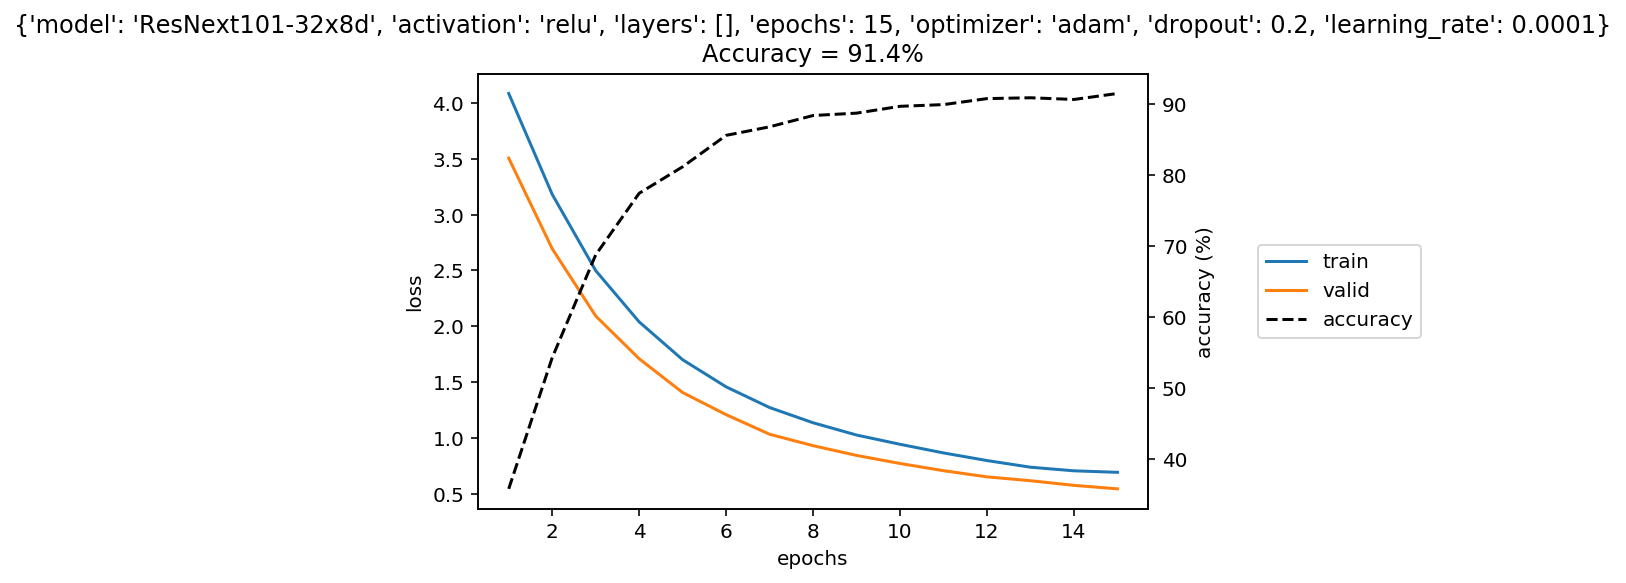

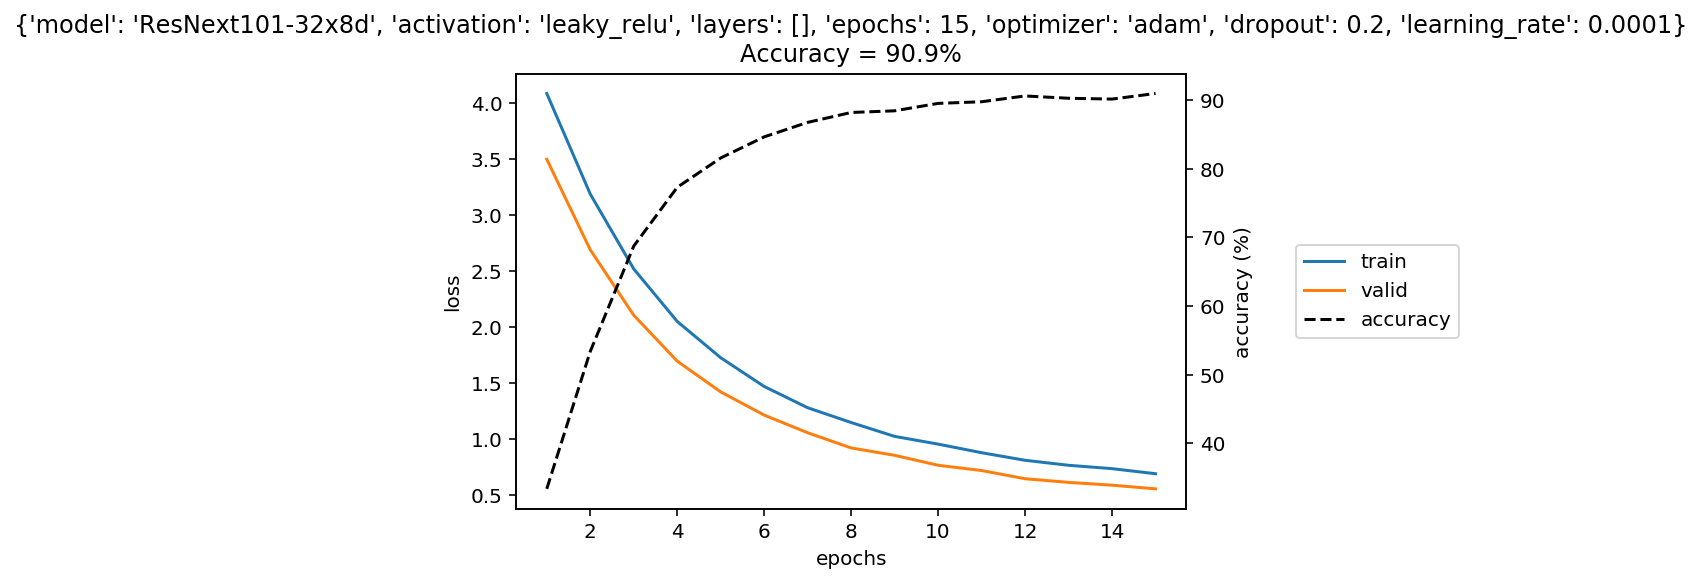

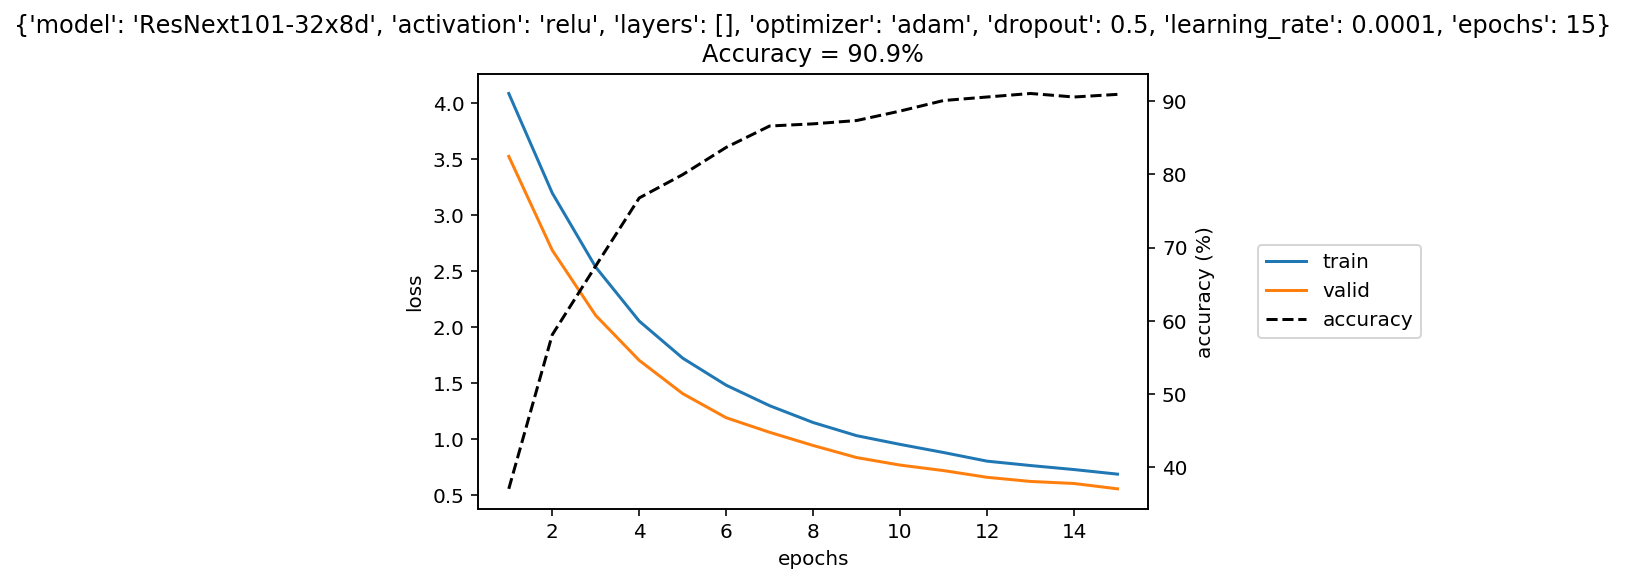

In [28]:
grid_search(configurations)

Adding layers and neurons per layers (in the classifier) does not necessarility improve the accuracy of the prediction: on the contrary and you also have cases where validation loss becomes higher than the training loss (over-fitting) even with regularization (dropouts). 

Adam optimizer seems to reach convergence a bit faster than SGD but requires a learning rate two orders of magnitude smaller, otherwise I have experienced some divergence in the training process (losses becoming really high). 

Dropout with a probability of 0.5 seems also to reduce the accuracy, validation loss reaches an asymptote which is higher than with a dropout of 0.2. 

The ResNet model provides a better accuracy but requires a few epochs more and is longer to train due to the added complexity of the feature-extractor layers compared to VGG16. 

I also needed to reduce the batch size for some architectures (the ones with more hidden layers in the classifiers and with more neurons) due to the fact I was missing some memory on my GPU. This affects the performance quite significantly. 

I experienced a lot of issues with CUDA memory when, whatever the reason, the fitting process raised Exception. The PyTorch module was not garbage-collected (probably because it was still references by mechanisms involved in the Exception process) and CUDA memory was not freed. Causing all subsequents trainings to fail due to lack of memory. For this reason, all operations requiring potentially CUDA are embedded into a *Context* preventing Exceptions to propagate but still displaying the traceback in the console or in the notebook.

Finally, we can get a decent performance without many efforts with a good feature-extractor because most of the hard work have been done before. So I guess the next step is to learn more on how to make a good feature-extractor ;) This transfer learning technique was completly new to me and I found it really powerfull.

Training the model with the best configuration:

In [29]:
max_accuracy = 0.
conf = None
for item in results:
    accuracy = item["accuracies"][-1]
    if accuracy > max_accuracy:
        conf = item["configuration"].copy()
        max_accuracy = accuracy
epochs = conf.pop('epochs')
print(conf)

{'model': 'ResNext101-32x8d', 'activation': 'relu', 'layers': [], 'optimizer': 'adam', 'dropout': 0.2, 'learning_rate': 0.0001}


In [30]:
clf = FlowerClassifier(**conf)
train_losses, valid_losses, accuracies, elapsed_times = clf.fit(train_loader, valid_loader, 15)

CUDA cache emptied.
Fitting the model using cuda:0 as device.
Epoch completion: 100.0% Images per second: 43.7 Elapsed time: 149.8 seconds
Epoch: 1/15 Training loss: 4.093 Valid loss: 3.506 Accuracy: 26.9%
Epoch completion: 100.0% Images per second: 41.3 Elapsed time: 317.6 seconds
Epoch: 2/15 Training loss: 3.207 Valid loss: 2.724 Accuracy: 51.8%
Epoch completion: 100.0% Images per second: 40.5 Elapsed time: 485.4 seconds
Epoch: 3/15 Training loss: 2.542 Valid loss: 2.111 Accuracy: 68.3%
Epoch completion: 100.0% Images per second: 40.0 Elapsed time: 656.0 seconds
Epoch: 4/15 Training loss: 2.060 Valid loss: 1.712 Accuracy: 77.7%
Epoch completion: 100.0% Images per second: 39.8 Elapsed time: 823.9 seconds
Epoch: 5/15 Training loss: 1.736 Valid loss: 1.421 Accuracy: 81.5%
Epoch completion: 100.0% Images per second: 39.6 Elapsed time: 991.9 seconds
Epoch: 6/15 Training loss: 1.482 Valid loss: 1.215 Accuracy: 82.8%
Epoch completion: 100.0% Images per second: 39.5 Elapsed time: 1159.8 seco

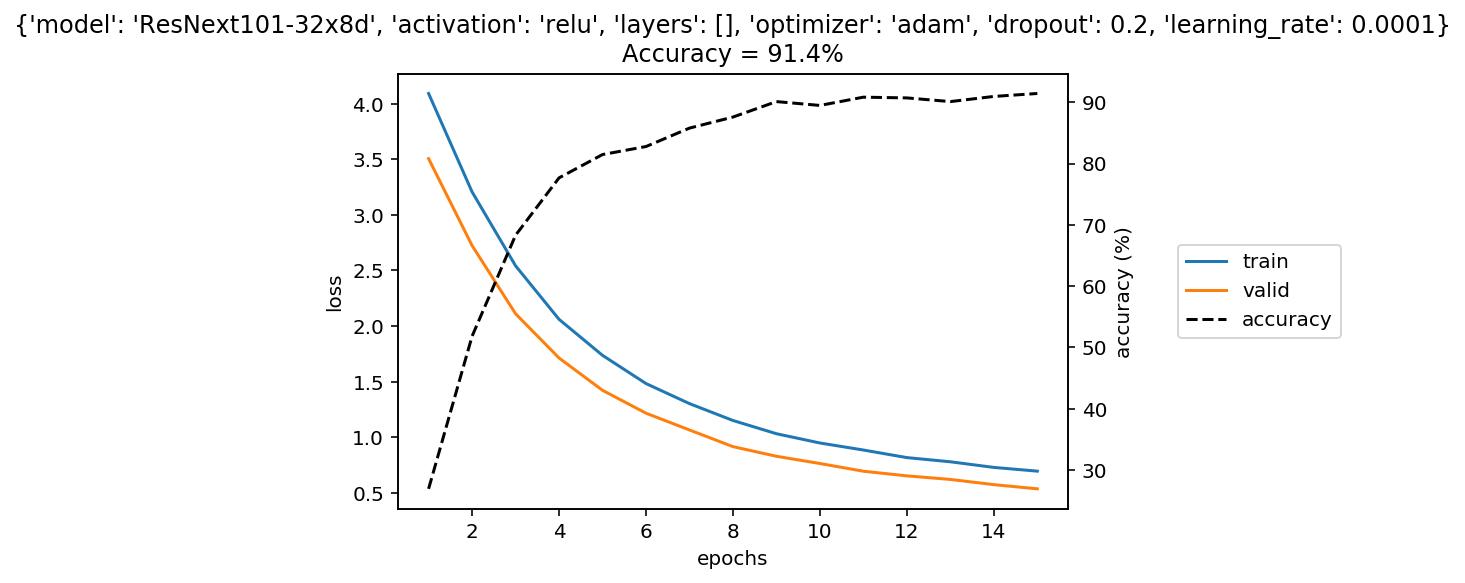

In [31]:
plot_history(train_losses, valid_losses, accuracies, conf)

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [32]:
loss, accuracy = clf.test(test_loader)

Testing the model using cuda:0 as device.
Testing loss: 0.606 Accuracy: 88.9%


The model has a decent accuracy on the testing dataset of 88.9%.

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [33]:
clf.save('model.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [34]:
clf = FlowerClassifier.load('model.pth')
print(clf.get_configuration())

CUDA cache emptied.
OrderedDict([('model', 'ResNext101-32x8d'), ('layers', []), ('dropout', 0.2), ('activation', 'relu'), ('optimizer', 'adam'), ('learning_rate', 0.0001)])


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [35]:
output = clf.process_image('/files/cedric/datasets/udacity/ai_nanodegree/flowers/test/10/image_07090.jpg')
tensor, before = output
print(tensor.shape)

torch.Size([3, 224, 224])


The tensor has the expected shape. Before any transformation the picture looks loke this:

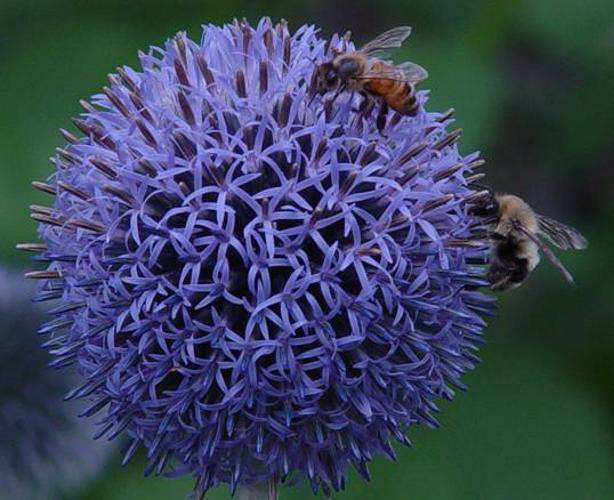

In [36]:
before

After transformation:

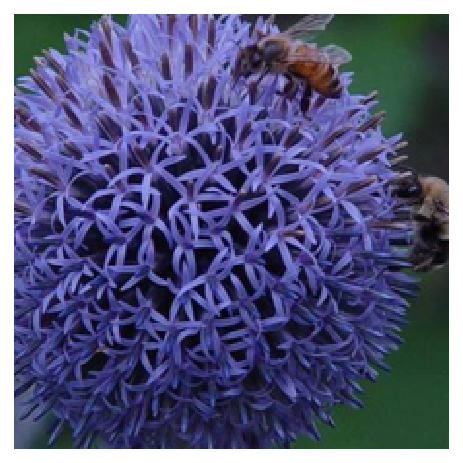

In [37]:
imshow(tensor);

We can also check that it works for pictures oriented differently:

In [38]:
output = clf.process_image('/files/cedric/datasets/udacity/ai_nanodegree/flowers/test/43/image_02346.jpg')
tensor, before = output
print(tensor.shape)

torch.Size([3, 224, 224])


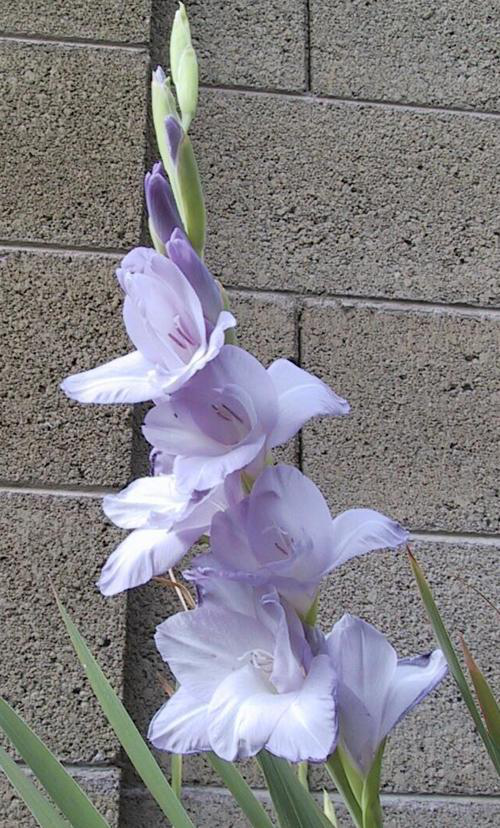

In [39]:
before

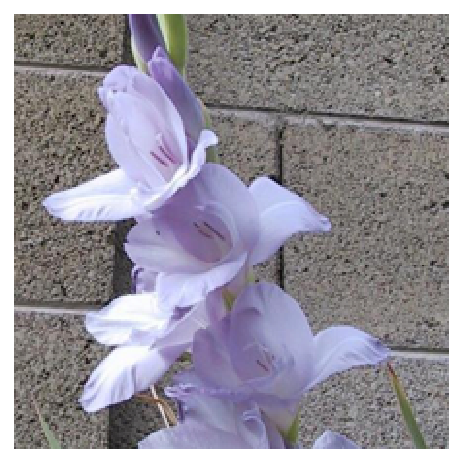

In [40]:
imshow(tensor);

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [70]:
output, tensor = clf.predict('/files/cedric/datasets/udacity/ai_nanodegree/flowers/test/87/image_05462.jpg')
print(output)

OrderedDict([('magnolia', 0.29250503), ('water lily', 0.21965349), ('clematis', 0.14598668), ('passion flower', 0.05298979), ('lotus lotus', 0.026825601)])


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

The neuron network correctly predicts magnolia for this one:

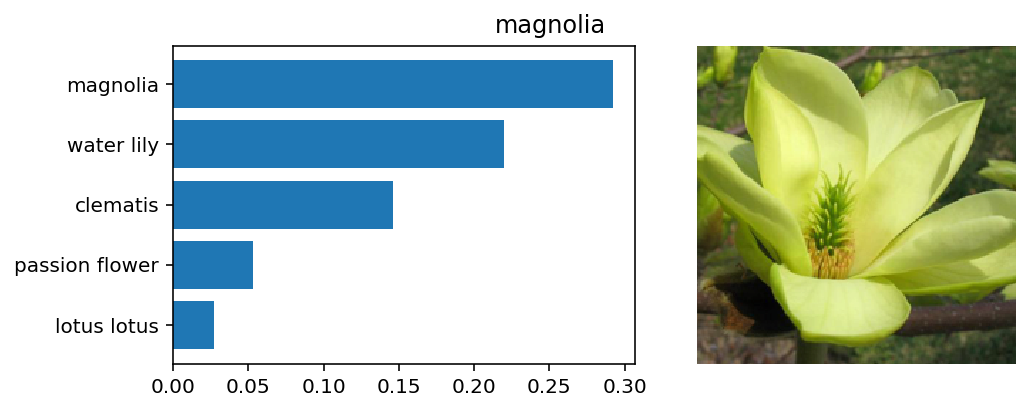

In [71]:
category_plot(output, tensor);

The probability for *water lily* is quite close and when we have a look at a *water lily* we can find some similarities:

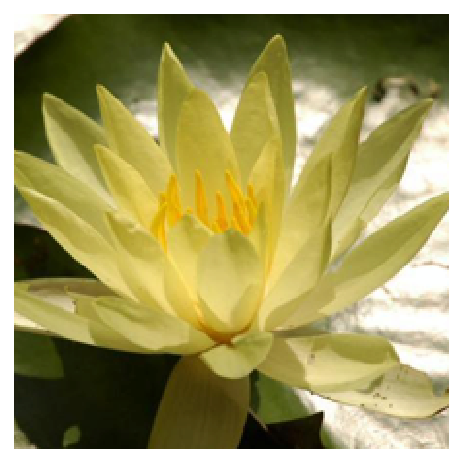

In [72]:
output = clf.process_image('/files/cedric/datasets/udacity/ai_nanodegree/flowers/test/73/image_00260.jpg')
tensor, before = output
imshow(tensor);

The next one is actually a globe thistle:

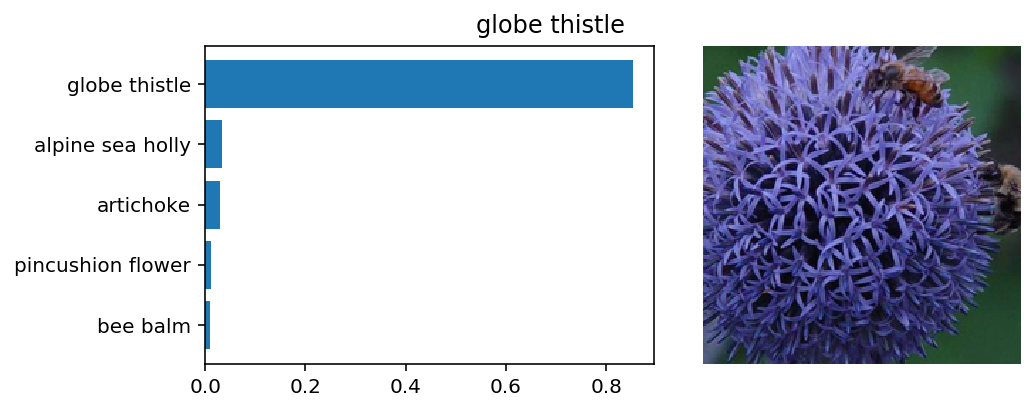

In [73]:
output, tensor = clf.predict('/files/cedric/datasets/udacity/ai_nanodegree/flowers/test/10/image_07090.jpg')
category_plot(output, tensor);

And this one an orange dhalia:

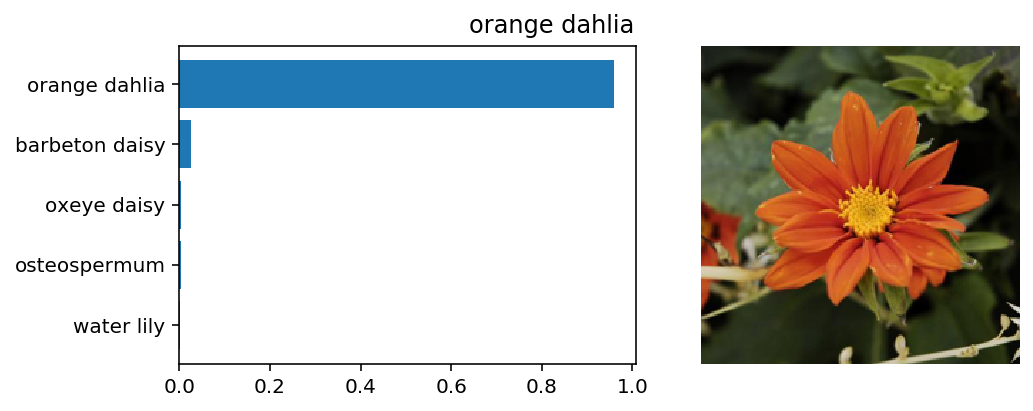

In [74]:
output, tensor = clf.predict('/files/cedric/datasets/udacity/ai_nanodegree/flowers/test/59/image_05038.jpg')
category_plot(output, tensor);

And the final one is also correctly predicted as being a sword lily:

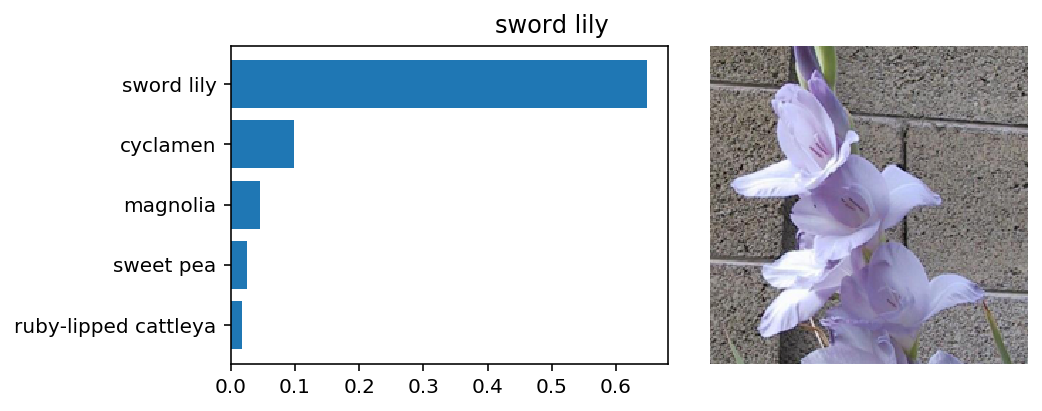

In [75]:
output, tensor = clf.predict('/files/cedric/datasets/udacity/ai_nanodegree/flowers/test/43/image_02346.jpg')
category_plot(output, tensor);

For the last three, the probability are much higher than with magnolia.

## Appendix

Additional resources used during the project completion:

<hr>

Torchvision documentation on [transformations](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision-transforms).

<hr>

PyTorch documentation on [modules](https://pytorch.org/docs/stable/nn.html#torch.nn.Module).

<hr>

PyTorch documentation on [optimizers](https://pytorch.org/docs/stable/optim.html#algorithms).

<hr>

Intialization of weights and bias with module on [StackOverflow](https://stackoverflow.com/a/49433937)

<hr>

[Recommandations](https://towardsdatascience.com/weight-initialization-techniques-in-neural-networks-26c649eb3b78) for weights and bias initialization.

<hr>

Initialization of weights and bias with [torch.nn.init](https://pytorch.org/docs/stable/nn.init.html#torch-nn-init)

<hr>

Regularization techniques for neural networks including [dropout and L2 regularization](https://towardsdatascience.com/how-to-improve-a-neural-network-with-regularization-8a18ecda9fe3).

<hr>

An [overview](https://ruder.io/optimizing-gradient-descent/index.html) of gradient descent algorithms.

<hr>

[ImageNet](http://www.image-net.org/) datasets on which PyTorch [models](https://pytorch.org/docs/stable/torchvision/models.html) have been pretrained.

<hr>
